In [286]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [288]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torch import device
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_curve, precision_recall_curve

torch.manual_seed(47)
np.random.seed(47)

In [289]:
class ResUnit(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(ResUnit, self).__init__()
        self.c1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.b1 = nn.BatchNorm2d(planes)
        self.c2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.b2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()

        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.relu(self.b1(self.c1(x)))
        out = self.b2(self.c2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNet18, self).__init__()
        self.in_planes = 64

        # Initial layer (Modified for 32x32 input like CIFAR)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # ResNet18 Stages: 2 blocks each with channels [64, 128, 256, 512]
        self.layer1 = self._make_layer(64,  2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(ResUnit(self.in_planes, planes, s))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        feat = torch.flatten(out, 1)
        out = self.fc(feat)
        return feat,out

# Training the model

In [290]:
lr =0.01
batch_size = 128
epochs = 400
weight_decay = 5e-4
crit = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [291]:
resnet = ResNet18(num_classes=100).to(device)
opti = torch.optim.SGD(resnet.parameters(), lr=lr, weight_decay=weight_decay,momentum = 0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opti, T_max=epochs)

In [292]:
transf = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

])
tr = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [293]:
train_data = torchvision.datasets.CIFAR100(
    root="./data", train=True, download=True, transform=transf
)
val_data = torchvision.datasets.CIFAR100(
    root="./data", train=False, download=True, transform=tr
)

In [294]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [295]:
import os
os.makedirs("/content/drive/MyDrive/models", exist_ok=True)

In [296]:
def train(resnet, crit, opti, scheduler, train_dataloader, val_dataloader, epochs, save=True):
    losses, accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(epochs):
        resnet.train()
        i = 0
        correct, total = 0, 0
        running_loss = 0.0

        for inputs, labels in tqdm(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            _ , outputs = resnet(inputs)
            loss = crit(outputs, labels)

            opti.zero_grad()
            loss.backward()
            opti.step()

            running_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)
            i += 1

        scheduler.step()

        train_loss = running_loss / i
        train_acc = correct / total
        losses.append(train_loss)
        accuracies.append(train_acc)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

        resnet.eval()
        val_correct, val_total = 0, 0
        val_running_loss = 0.0

        with torch.no_grad():
            for val_in, val_l in val_dataloader:
                val_in, val_l = val_in.to(device), val_l.to(device)
                _, val_out = resnet(val_in)
                v_loss = crit(val_out, val_l)

                val_running_loss += v_loss.item()
                val_correct += (val_out.argmax(dim=1) == val_l).sum().item()
                val_total += val_l.size(0)

        val_loss_avg = val_running_loss / len(val_dataloader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)

        print(f"Validation Loss: {val_loss_avg:.4f}, Validation Accuracy: {val_acc:.4f}")

        if save and (epoch + 1) % 10 == 0:
            save_path = f"/content/drive/MyDrive/models/resnet_{epoch+1}_epoch.pth"
            torch.save({
                'model_state_dict': resnet.state_dict(),
                'optimizer_state_dict': opti.state_dict(),
                'sheduler_state_dict': scheduler.state_dict(),
                'epoch': epoch + 1,
                'loss': train_loss,
                'train_losses': losses,
                'train_accuracies': accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }, save_path)
            print(f"Successfully saved checkpoint to {save_path}")

    return losses, accuracies, val_losses, val_accuracies

Uncomment this if you want to train !

In [26]:
#losses, accuracies, val_losses, val_accuracies = train(resnet,crit,opti,scheduler,train_dataloader,val_dataloader,epochs)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/400, Loss: 3.6723, Accuracy: 0.1377
Validation Loss: 3.2788, Validation Accuracy: 0.2119


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/400, Loss: 2.8587, Accuracy: 0.2774
Validation Loss: 2.6978, Validation Accuracy: 0.3185


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/400, Loss: 2.3500, Accuracy: 0.3807
Validation Loss: 2.3944, Validation Accuracy: 0.3755


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/400, Loss: 2.0105, Accuracy: 0.4555
Validation Loss: 2.0955, Validation Accuracy: 0.4395


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/400, Loss: 1.7721, Accuracy: 0.5081
Validation Loss: 2.1566, Validation Accuracy: 0.4473


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/400, Loss: 1.6112, Accuracy: 0.5461
Validation Loss: 1.7677, Validation Accuracy: 0.5243


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/400, Loss: 1.4709, Accuracy: 0.5826
Validation Loss: 1.7456, Validation Accuracy: 0.5295


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/400, Loss: 1.3553, Accuracy: 0.6098
Validation Loss: 1.5730, Validation Accuracy: 0.5645


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/400, Loss: 1.2574, Accuracy: 0.6354
Validation Loss: 1.5420, Validation Accuracy: 0.5767


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/400, Loss: 1.1681, Accuracy: 0.6574
Validation Loss: 1.4762, Validation Accuracy: 0.5826
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_10_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11/400, Loss: 1.1021, Accuracy: 0.6759
Validation Loss: 1.4724, Validation Accuracy: 0.5900


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12/400, Loss: 1.0312, Accuracy: 0.6940
Validation Loss: 1.4110, Validation Accuracy: 0.6081


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13/400, Loss: 0.9600, Accuracy: 0.7134
Validation Loss: 1.3518, Validation Accuracy: 0.6241


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14/400, Loss: 0.9071, Accuracy: 0.7281
Validation Loss: 1.3962, Validation Accuracy: 0.6169


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15/400, Loss: 0.8527, Accuracy: 0.7434
Validation Loss: 1.4780, Validation Accuracy: 0.6086


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16/400, Loss: 0.8003, Accuracy: 0.7578
Validation Loss: 1.3390, Validation Accuracy: 0.6340


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17/400, Loss: 0.7597, Accuracy: 0.7683
Validation Loss: 1.3630, Validation Accuracy: 0.6354


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18/400, Loss: 0.7098, Accuracy: 0.7848
Validation Loss: 1.3571, Validation Accuracy: 0.6383


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19/400, Loss: 0.6640, Accuracy: 0.7958
Validation Loss: 1.3162, Validation Accuracy: 0.6557


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20/400, Loss: 0.6293, Accuracy: 0.8065
Validation Loss: 1.2985, Validation Accuracy: 0.6575
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_20_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21/400, Loss: 0.5967, Accuracy: 0.8177
Validation Loss: 1.3507, Validation Accuracy: 0.6481


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22/400, Loss: 0.5551, Accuracy: 0.8269
Validation Loss: 1.3877, Validation Accuracy: 0.6428


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23/400, Loss: 0.5168, Accuracy: 0.8393
Validation Loss: 1.3353, Validation Accuracy: 0.6457


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24/400, Loss: 0.4853, Accuracy: 0.8510
Validation Loss: 1.2865, Validation Accuracy: 0.6656


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25/400, Loss: 0.4585, Accuracy: 0.8572
Validation Loss: 1.4162, Validation Accuracy: 0.6472


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26/400, Loss: 0.4372, Accuracy: 0.8638
Validation Loss: 1.3523, Validation Accuracy: 0.6471


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27/400, Loss: 0.4061, Accuracy: 0.8730
Validation Loss: 1.3302, Validation Accuracy: 0.6650


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28/400, Loss: 0.3724, Accuracy: 0.8865
Validation Loss: 1.3067, Validation Accuracy: 0.6687


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29/400, Loss: 0.3510, Accuracy: 0.8922
Validation Loss: 1.2875, Validation Accuracy: 0.6799


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30/400, Loss: 0.3275, Accuracy: 0.8996
Validation Loss: 1.2498, Validation Accuracy: 0.6823
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_30_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31/400, Loss: 0.3066, Accuracy: 0.9059
Validation Loss: 1.3314, Validation Accuracy: 0.6643


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32/400, Loss: 0.2903, Accuracy: 0.9122
Validation Loss: 1.3242, Validation Accuracy: 0.6734


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33/400, Loss: 0.2669, Accuracy: 0.9196
Validation Loss: 1.3250, Validation Accuracy: 0.6801


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34/400, Loss: 0.2520, Accuracy: 0.9244
Validation Loss: 1.3499, Validation Accuracy: 0.6721


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35/400, Loss: 0.2498, Accuracy: 0.9252
Validation Loss: 1.2986, Validation Accuracy: 0.6789


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36/400, Loss: 0.2331, Accuracy: 0.9308
Validation Loss: 1.2999, Validation Accuracy: 0.6834


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37/400, Loss: 0.2213, Accuracy: 0.9337
Validation Loss: 1.2967, Validation Accuracy: 0.6874


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38/400, Loss: 0.1972, Accuracy: 0.9429
Validation Loss: 1.3079, Validation Accuracy: 0.6860


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39/400, Loss: 0.1890, Accuracy: 0.9464
Validation Loss: 1.3614, Validation Accuracy: 0.6745


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40/400, Loss: 0.1712, Accuracy: 0.9518
Validation Loss: 1.3672, Validation Accuracy: 0.6787
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_40_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41/400, Loss: 0.1617, Accuracy: 0.9556
Validation Loss: 1.3993, Validation Accuracy: 0.6778


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42/400, Loss: 0.1652, Accuracy: 0.9533
Validation Loss: 1.4118, Validation Accuracy: 0.6712


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43/400, Loss: 0.1748, Accuracy: 0.9505
Validation Loss: 1.2826, Validation Accuracy: 0.6910


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44/400, Loss: 0.1598, Accuracy: 0.9563
Validation Loss: 1.3603, Validation Accuracy: 0.6880


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45/400, Loss: 0.1501, Accuracy: 0.9594
Validation Loss: 1.2966, Validation Accuracy: 0.6903


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46/400, Loss: 0.1417, Accuracy: 0.9625
Validation Loss: 1.2977, Validation Accuracy: 0.6942


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47/400, Loss: 0.1317, Accuracy: 0.9655
Validation Loss: 1.3752, Validation Accuracy: 0.6835


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48/400, Loss: 0.1309, Accuracy: 0.9656
Validation Loss: 1.3879, Validation Accuracy: 0.6791


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49/400, Loss: 0.1293, Accuracy: 0.9668
Validation Loss: 1.3333, Validation Accuracy: 0.6873


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50/400, Loss: 0.1263, Accuracy: 0.9661
Validation Loss: 1.2769, Validation Accuracy: 0.6997
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_50_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 51/400, Loss: 0.1198, Accuracy: 0.9691
Validation Loss: 1.3075, Validation Accuracy: 0.6962


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 52/400, Loss: 0.1271, Accuracy: 0.9670
Validation Loss: 1.2916, Validation Accuracy: 0.6980


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 53/400, Loss: 0.1200, Accuracy: 0.9688
Validation Loss: 1.3161, Validation Accuracy: 0.6896


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 54/400, Loss: 0.1220, Accuracy: 0.9684
Validation Loss: 1.3319, Validation Accuracy: 0.6885


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 55/400, Loss: 0.1077, Accuracy: 0.9742
Validation Loss: 1.3236, Validation Accuracy: 0.6932


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 56/400, Loss: 0.1059, Accuracy: 0.9741
Validation Loss: 1.3213, Validation Accuracy: 0.6942


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 57/400, Loss: 0.1121, Accuracy: 0.9720
Validation Loss: 1.3111, Validation Accuracy: 0.6929


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 58/400, Loss: 0.1092, Accuracy: 0.9716
Validation Loss: 1.3504, Validation Accuracy: 0.6927


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 59/400, Loss: 0.1156, Accuracy: 0.9703
Validation Loss: 1.2958, Validation Accuracy: 0.6944


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 60/400, Loss: 0.1108, Accuracy: 0.9724
Validation Loss: 1.3876, Validation Accuracy: 0.6845
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_60_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 61/400, Loss: 0.1075, Accuracy: 0.9726
Validation Loss: 1.3347, Validation Accuracy: 0.6901


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 62/400, Loss: 0.1194, Accuracy: 0.9688
Validation Loss: 1.4290, Validation Accuracy: 0.6764


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 63/400, Loss: 0.1210, Accuracy: 0.9689
Validation Loss: 1.4009, Validation Accuracy: 0.6894


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 64/400, Loss: 0.1171, Accuracy: 0.9704
Validation Loss: 1.2838, Validation Accuracy: 0.7024


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 65/400, Loss: 0.1092, Accuracy: 0.9723
Validation Loss: 1.2932, Validation Accuracy: 0.7003


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 66/400, Loss: 0.1037, Accuracy: 0.9735
Validation Loss: 1.2756, Validation Accuracy: 0.7038


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 67/400, Loss: 0.1021, Accuracy: 0.9749
Validation Loss: 1.3083, Validation Accuracy: 0.6987


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 68/400, Loss: 0.1090, Accuracy: 0.9719
Validation Loss: 1.3187, Validation Accuracy: 0.6916


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 69/400, Loss: 0.1068, Accuracy: 0.9727
Validation Loss: 1.3069, Validation Accuracy: 0.6926


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 70/400, Loss: 0.1117, Accuracy: 0.9720
Validation Loss: 1.2995, Validation Accuracy: 0.6972
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_70_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 71/400, Loss: 0.0982, Accuracy: 0.9762
Validation Loss: 1.3388, Validation Accuracy: 0.6867


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 72/400, Loss: 0.0858, Accuracy: 0.9802
Validation Loss: 1.3451, Validation Accuracy: 0.6960


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 73/400, Loss: 0.0953, Accuracy: 0.9769
Validation Loss: 1.3300, Validation Accuracy: 0.6937


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 74/400, Loss: 0.1095, Accuracy: 0.9720
Validation Loss: 1.3507, Validation Accuracy: 0.6913


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 75/400, Loss: 0.1062, Accuracy: 0.9738
Validation Loss: 1.2911, Validation Accuracy: 0.6982


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 76/400, Loss: 0.1024, Accuracy: 0.9755
Validation Loss: 1.3415, Validation Accuracy: 0.6935


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 77/400, Loss: 0.1012, Accuracy: 0.9745
Validation Loss: 1.3530, Validation Accuracy: 0.6920


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 78/400, Loss: 0.0936, Accuracy: 0.9774
Validation Loss: 1.3204, Validation Accuracy: 0.6915


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 79/400, Loss: 0.0973, Accuracy: 0.9761
Validation Loss: 1.3100, Validation Accuracy: 0.6953


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 80/400, Loss: 0.0915, Accuracy: 0.9778
Validation Loss: 1.3638, Validation Accuracy: 0.6898
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_80_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 81/400, Loss: 0.0904, Accuracy: 0.9781
Validation Loss: 1.3589, Validation Accuracy: 0.6891


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 82/400, Loss: 0.1008, Accuracy: 0.9751
Validation Loss: 1.3356, Validation Accuracy: 0.6870


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 83/400, Loss: 0.0985, Accuracy: 0.9754
Validation Loss: 1.3655, Validation Accuracy: 0.6862


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 84/400, Loss: 0.1012, Accuracy: 0.9754
Validation Loss: 1.3080, Validation Accuracy: 0.6965


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 85/400, Loss: 0.0927, Accuracy: 0.9772
Validation Loss: 1.3399, Validation Accuracy: 0.6936


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 86/400, Loss: 0.0818, Accuracy: 0.9818
Validation Loss: 1.3199, Validation Accuracy: 0.6953


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 87/400, Loss: 0.0890, Accuracy: 0.9783
Validation Loss: 1.3472, Validation Accuracy: 0.6954


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 88/400, Loss: 0.1065, Accuracy: 0.9729
Validation Loss: 1.3632, Validation Accuracy: 0.6889


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 89/400, Loss: 0.1004, Accuracy: 0.9755
Validation Loss: 1.3830, Validation Accuracy: 0.6847


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 90/400, Loss: 0.0956, Accuracy: 0.9763
Validation Loss: 1.3847, Validation Accuracy: 0.6841
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_90_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 91/400, Loss: 0.1013, Accuracy: 0.9746
Validation Loss: 1.3183, Validation Accuracy: 0.6989


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 92/400, Loss: 0.0980, Accuracy: 0.9757
Validation Loss: 1.3783, Validation Accuracy: 0.6878


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 93/400, Loss: 0.0916, Accuracy: 0.9776
Validation Loss: 1.3075, Validation Accuracy: 0.7002


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 94/400, Loss: 0.0870, Accuracy: 0.9793
Validation Loss: 1.3067, Validation Accuracy: 0.6948


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 95/400, Loss: 0.0868, Accuracy: 0.9791
Validation Loss: 1.3000, Validation Accuracy: 0.6977


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 96/400, Loss: 0.0786, Accuracy: 0.9817
Validation Loss: 1.2908, Validation Accuracy: 0.7011


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 97/400, Loss: 0.0748, Accuracy: 0.9832
Validation Loss: 1.3359, Validation Accuracy: 0.6964


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 98/400, Loss: 0.0737, Accuracy: 0.9829
Validation Loss: 1.2682, Validation Accuracy: 0.6991


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 99/400, Loss: 0.0760, Accuracy: 0.9823
Validation Loss: 1.3414, Validation Accuracy: 0.6897


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 100/400, Loss: 0.0822, Accuracy: 0.9802
Validation Loss: 1.3684, Validation Accuracy: 0.6865
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_100_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 101/400, Loss: 0.0839, Accuracy: 0.9798
Validation Loss: 1.3747, Validation Accuracy: 0.6841


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 102/400, Loss: 0.0913, Accuracy: 0.9776
Validation Loss: 1.3746, Validation Accuracy: 0.6820


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 103/400, Loss: 0.1022, Accuracy: 0.9743
Validation Loss: 1.3296, Validation Accuracy: 0.6898


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 104/400, Loss: 0.0810, Accuracy: 0.9809
Validation Loss: 1.3356, Validation Accuracy: 0.6959


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 105/400, Loss: 0.0713, Accuracy: 0.9840
Validation Loss: 1.2940, Validation Accuracy: 0.7037


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 106/400, Loss: 0.0733, Accuracy: 0.9842
Validation Loss: 1.2638, Validation Accuracy: 0.7062


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 107/400, Loss: 0.0747, Accuracy: 0.9829
Validation Loss: 1.3221, Validation Accuracy: 0.7007


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 108/400, Loss: 0.0698, Accuracy: 0.9843
Validation Loss: 1.3818, Validation Accuracy: 0.6873


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 109/400, Loss: 0.0744, Accuracy: 0.9828
Validation Loss: 1.2765, Validation Accuracy: 0.7017


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 110/400, Loss: 0.0760, Accuracy: 0.9825
Validation Loss: 1.2941, Validation Accuracy: 0.7076
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_110_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 111/400, Loss: 0.0730, Accuracy: 0.9832
Validation Loss: 1.3689, Validation Accuracy: 0.6922


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 112/400, Loss: 0.0809, Accuracy: 0.9806
Validation Loss: 1.3124, Validation Accuracy: 0.6943


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 113/400, Loss: 0.0882, Accuracy: 0.9794
Validation Loss: 1.4087, Validation Accuracy: 0.6853


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 114/400, Loss: 0.0904, Accuracy: 0.9784
Validation Loss: 1.3650, Validation Accuracy: 0.6910


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 115/400, Loss: 0.0853, Accuracy: 0.9805
Validation Loss: 1.3123, Validation Accuracy: 0.6942


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 116/400, Loss: 0.0900, Accuracy: 0.9777
Validation Loss: 1.4017, Validation Accuracy: 0.6800


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 117/400, Loss: 0.0892, Accuracy: 0.9779
Validation Loss: 1.3571, Validation Accuracy: 0.6918


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 118/400, Loss: 0.0820, Accuracy: 0.9808
Validation Loss: 1.3652, Validation Accuracy: 0.6947


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 119/400, Loss: 0.0806, Accuracy: 0.9813
Validation Loss: 1.3393, Validation Accuracy: 0.6996


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 120/400, Loss: 0.0827, Accuracy: 0.9796
Validation Loss: 1.2852, Validation Accuracy: 0.7040
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_120_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 121/400, Loss: 0.0774, Accuracy: 0.9817
Validation Loss: 1.3556, Validation Accuracy: 0.6894


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 122/400, Loss: 0.0656, Accuracy: 0.9850
Validation Loss: 1.2807, Validation Accuracy: 0.7058


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 123/400, Loss: 0.0619, Accuracy: 0.9861
Validation Loss: 1.2447, Validation Accuracy: 0.7139


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 124/400, Loss: 0.0507, Accuracy: 0.9890
Validation Loss: 1.2620, Validation Accuracy: 0.7102


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 125/400, Loss: 0.0507, Accuracy: 0.9900
Validation Loss: 1.3516, Validation Accuracy: 0.6942


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 126/400, Loss: 0.0512, Accuracy: 0.9888
Validation Loss: 1.3467, Validation Accuracy: 0.6909


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 127/400, Loss: 0.0582, Accuracy: 0.9878
Validation Loss: 1.2454, Validation Accuracy: 0.7073


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 128/400, Loss: 0.0623, Accuracy: 0.9862
Validation Loss: 1.3261, Validation Accuracy: 0.6995


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 129/400, Loss: 0.0576, Accuracy: 0.9881
Validation Loss: 1.2839, Validation Accuracy: 0.7109


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 130/400, Loss: 0.0688, Accuracy: 0.9843
Validation Loss: 1.3857, Validation Accuracy: 0.6881
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_130_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 131/400, Loss: 0.0757, Accuracy: 0.9825
Validation Loss: 1.3361, Validation Accuracy: 0.6919


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 132/400, Loss: 0.0833, Accuracy: 0.9808
Validation Loss: 1.4287, Validation Accuracy: 0.6792


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 133/400, Loss: 0.0878, Accuracy: 0.9791
Validation Loss: 1.3298, Validation Accuracy: 0.6925


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 134/400, Loss: 0.1020, Accuracy: 0.9746
Validation Loss: 1.3969, Validation Accuracy: 0.6815


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 135/400, Loss: 0.0984, Accuracy: 0.9753
Validation Loss: 1.3809, Validation Accuracy: 0.6824


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 136/400, Loss: 0.0802, Accuracy: 0.9816
Validation Loss: 1.2715, Validation Accuracy: 0.7068


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 137/400, Loss: 0.0584, Accuracy: 0.9868
Validation Loss: 1.3412, Validation Accuracy: 0.6972


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 138/400, Loss: 0.0624, Accuracy: 0.9858
Validation Loss: 1.3431, Validation Accuracy: 0.6890


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 139/400, Loss: 0.0480, Accuracy: 0.9905
Validation Loss: 1.2552, Validation Accuracy: 0.7114


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 140/400, Loss: 0.0479, Accuracy: 0.9896
Validation Loss: 1.3289, Validation Accuracy: 0.6936
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_140_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 141/400, Loss: 0.0513, Accuracy: 0.9893
Validation Loss: 1.3032, Validation Accuracy: 0.7050


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 142/400, Loss: 0.0502, Accuracy: 0.9896
Validation Loss: 1.2814, Validation Accuracy: 0.7084


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 143/400, Loss: 0.0548, Accuracy: 0.9888
Validation Loss: 1.2395, Validation Accuracy: 0.7139


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 144/400, Loss: 0.0403, Accuracy: 0.9926
Validation Loss: 1.2121, Validation Accuracy: 0.7177


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 145/400, Loss: 0.0385, Accuracy: 0.9922
Validation Loss: 1.2077, Validation Accuracy: 0.7194


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 146/400, Loss: 0.0283, Accuracy: 0.9954
Validation Loss: 1.1593, Validation Accuracy: 0.7260


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 147/400, Loss: 0.0314, Accuracy: 0.9945
Validation Loss: 1.2612, Validation Accuracy: 0.7102


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 148/400, Loss: 0.0311, Accuracy: 0.9950
Validation Loss: 1.1615, Validation Accuracy: 0.7276


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 149/400, Loss: 0.0227, Accuracy: 0.9968
Validation Loss: 1.1297, Validation Accuracy: 0.7407


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 150/400, Loss: 0.0223, Accuracy: 0.9969
Validation Loss: 1.1281, Validation Accuracy: 0.7400
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_150_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 151/400, Loss: 0.0201, Accuracy: 0.9974
Validation Loss: 1.1323, Validation Accuracy: 0.7351


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 152/400, Loss: 0.0187, Accuracy: 0.9979
Validation Loss: 1.1415, Validation Accuracy: 0.7337


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 153/400, Loss: 0.0186, Accuracy: 0.9978
Validation Loss: 1.1272, Validation Accuracy: 0.7366


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 154/400, Loss: 0.0149, Accuracy: 0.9984
Validation Loss: 1.1235, Validation Accuracy: 0.7433


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 155/400, Loss: 0.0168, Accuracy: 0.9979
Validation Loss: 1.1200, Validation Accuracy: 0.7382


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 156/400, Loss: 0.0276, Accuracy: 0.9955
Validation Loss: 1.1718, Validation Accuracy: 0.7310


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 157/400, Loss: 0.0192, Accuracy: 0.9978
Validation Loss: 1.1208, Validation Accuracy: 0.7382


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 158/400, Loss: 0.0150, Accuracy: 0.9985
Validation Loss: 1.0692, Validation Accuracy: 0.7452


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 159/400, Loss: 0.0167, Accuracy: 0.9982
Validation Loss: 1.0804, Validation Accuracy: 0.7434


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 160/400, Loss: 0.0140, Accuracy: 0.9988
Validation Loss: 1.0639, Validation Accuracy: 0.7489
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_160_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 161/400, Loss: 0.0147, Accuracy: 0.9984
Validation Loss: 1.1086, Validation Accuracy: 0.7386


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 162/400, Loss: 0.0180, Accuracy: 0.9980
Validation Loss: 1.1268, Validation Accuracy: 0.7333


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 163/400, Loss: 0.0254, Accuracy: 0.9963
Validation Loss: 1.1558, Validation Accuracy: 0.7285


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 164/400, Loss: 0.0320, Accuracy: 0.9958
Validation Loss: 1.2209, Validation Accuracy: 0.7143


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 165/400, Loss: 0.0438, Accuracy: 0.9935
Validation Loss: 1.3451, Validation Accuracy: 0.6801


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 166/400, Loss: 0.2126, Accuracy: 0.9438
Validation Loss: 1.7991, Validation Accuracy: 0.5964


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 167/400, Loss: 0.3053, Accuracy: 0.9157
Validation Loss: 1.4632, Validation Accuracy: 0.6521


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 168/400, Loss: 0.2198, Accuracy: 0.9402
Validation Loss: 1.5147, Validation Accuracy: 0.6547


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 169/400, Loss: 0.1692, Accuracy: 0.9546
Validation Loss: 1.4717, Validation Accuracy: 0.6639


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 170/400, Loss: 0.1351, Accuracy: 0.9656
Validation Loss: 1.3840, Validation Accuracy: 0.6865
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_170_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 171/400, Loss: 0.1062, Accuracy: 0.9738
Validation Loss: 1.2836, Validation Accuracy: 0.7009


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 172/400, Loss: 0.0803, Accuracy: 0.9813
Validation Loss: 1.3218, Validation Accuracy: 0.6940


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 173/400, Loss: 0.0679, Accuracy: 0.9850
Validation Loss: 1.2960, Validation Accuracy: 0.6993


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 174/400, Loss: 0.0699, Accuracy: 0.9835
Validation Loss: 1.2758, Validation Accuracy: 0.7067


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 175/400, Loss: 0.0495, Accuracy: 0.9896
Validation Loss: 1.2420, Validation Accuracy: 0.7140


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 176/400, Loss: 0.0435, Accuracy: 0.9913
Validation Loss: 1.2052, Validation Accuracy: 0.7245


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 177/400, Loss: 0.0358, Accuracy: 0.9932
Validation Loss: 1.1949, Validation Accuracy: 0.7260


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 178/400, Loss: 0.0284, Accuracy: 0.9953
Validation Loss: 1.1565, Validation Accuracy: 0.7346


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 179/400, Loss: 0.0221, Accuracy: 0.9965
Validation Loss: 1.1445, Validation Accuracy: 0.7334


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 180/400, Loss: 0.0263, Accuracy: 0.9957
Validation Loss: 1.1499, Validation Accuracy: 0.7304
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_180_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 181/400, Loss: 0.0204, Accuracy: 0.9971
Validation Loss: 1.1680, Validation Accuracy: 0.7308


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 182/400, Loss: 0.0208, Accuracy: 0.9970
Validation Loss: 1.1043, Validation Accuracy: 0.7404


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 183/400, Loss: 0.0149, Accuracy: 0.9984
Validation Loss: 1.0736, Validation Accuracy: 0.7487


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 184/400, Loss: 0.0110, Accuracy: 0.9989
Validation Loss: 1.0617, Validation Accuracy: 0.7519


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 185/400, Loss: 0.0119, Accuracy: 0.9988
Validation Loss: 1.0456, Validation Accuracy: 0.7520


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 186/400, Loss: 0.0094, Accuracy: 0.9992
Validation Loss: 1.0268, Validation Accuracy: 0.7566


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 187/400, Loss: 0.0077, Accuracy: 0.9994
Validation Loss: 1.0279, Validation Accuracy: 0.7577


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 188/400, Loss: 0.0076, Accuracy: 0.9993
Validation Loss: 1.0363, Validation Accuracy: 0.7528


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 189/400, Loss: 0.0083, Accuracy: 0.9994
Validation Loss: 1.0093, Validation Accuracy: 0.7606


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 190/400, Loss: 0.0077, Accuracy: 0.9993
Validation Loss: 1.0047, Validation Accuracy: 0.7595
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_190_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 191/400, Loss: 0.0068, Accuracy: 0.9995
Validation Loss: 1.0012, Validation Accuracy: 0.7589


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 192/400, Loss: 0.0075, Accuracy: 0.9994
Validation Loss: 0.9994, Validation Accuracy: 0.7601


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 193/400, Loss: 0.0070, Accuracy: 0.9996
Validation Loss: 0.9873, Validation Accuracy: 0.7617


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 194/400, Loss: 0.0072, Accuracy: 0.9995
Validation Loss: 0.9916, Validation Accuracy: 0.7592


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 195/400, Loss: 0.0071, Accuracy: 0.9995
Validation Loss: 0.9882, Validation Accuracy: 0.7613


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 196/400, Loss: 0.0070, Accuracy: 0.9997
Validation Loss: 0.9943, Validation Accuracy: 0.7589


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 197/400, Loss: 0.0075, Accuracy: 0.9996
Validation Loss: 0.9787, Validation Accuracy: 0.7646


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 198/400, Loss: 0.0079, Accuracy: 0.9995
Validation Loss: 0.9815, Validation Accuracy: 0.7644


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 199/400, Loss: 0.0077, Accuracy: 0.9995
Validation Loss: 0.9828, Validation Accuracy: 0.7615


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 200/400, Loss: 0.0076, Accuracy: 0.9996
Validation Loss: 0.9838, Validation Accuracy: 0.7639
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_200_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 201/400, Loss: 0.0077, Accuracy: 0.9996
Validation Loss: 0.9749, Validation Accuracy: 0.7655


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 202/400, Loss: 0.0074, Accuracy: 0.9996
Validation Loss: 0.9846, Validation Accuracy: 0.7637


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 203/400, Loss: 0.0078, Accuracy: 0.9996
Validation Loss: 0.9867, Validation Accuracy: 0.7647


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 204/400, Loss: 0.0090, Accuracy: 0.9994
Validation Loss: 0.9922, Validation Accuracy: 0.7604


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 205/400, Loss: 0.0083, Accuracy: 0.9995
Validation Loss: 0.9776, Validation Accuracy: 0.7633


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 206/400, Loss: 0.0083, Accuracy: 0.9996
Validation Loss: 0.9806, Validation Accuracy: 0.7638


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 207/400, Loss: 0.0083, Accuracy: 0.9995
Validation Loss: 0.9747, Validation Accuracy: 0.7660


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 208/400, Loss: 0.0084, Accuracy: 0.9995
Validation Loss: 0.9768, Validation Accuracy: 0.7626


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 209/400, Loss: 0.0082, Accuracy: 0.9996
Validation Loss: 0.9779, Validation Accuracy: 0.7639


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 210/400, Loss: 0.0090, Accuracy: 0.9995
Validation Loss: 0.9773, Validation Accuracy: 0.7649
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_210_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 211/400, Loss: 0.0086, Accuracy: 0.9996
Validation Loss: 0.9902, Validation Accuracy: 0.7632


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 212/400, Loss: 0.0087, Accuracy: 0.9996
Validation Loss: 0.9813, Validation Accuracy: 0.7653


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 213/400, Loss: 0.0084, Accuracy: 0.9996
Validation Loss: 0.9834, Validation Accuracy: 0.7621


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 214/400, Loss: 0.0087, Accuracy: 0.9996
Validation Loss: 0.9849, Validation Accuracy: 0.7629


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 215/400, Loss: 0.0083, Accuracy: 0.9996
Validation Loss: 0.9889, Validation Accuracy: 0.7655


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 216/400, Loss: 0.0094, Accuracy: 0.9996
Validation Loss: 1.0000, Validation Accuracy: 0.7611


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 217/400, Loss: 0.0093, Accuracy: 0.9996
Validation Loss: 0.9921, Validation Accuracy: 0.7614


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 218/400, Loss: 0.0094, Accuracy: 0.9996
Validation Loss: 0.9941, Validation Accuracy: 0.7624


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 219/400, Loss: 0.0096, Accuracy: 0.9996
Validation Loss: 0.9970, Validation Accuracy: 0.7608


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 220/400, Loss: 0.0093, Accuracy: 0.9996
Validation Loss: 0.9887, Validation Accuracy: 0.7628
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_220_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 221/400, Loss: 0.0141, Accuracy: 0.9990
Validation Loss: 1.0308, Validation Accuracy: 0.7525


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 222/400, Loss: 0.0175, Accuracy: 0.9985
Validation Loss: 1.1268, Validation Accuracy: 0.7370


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 223/400, Loss: 0.0689, Accuracy: 0.9889
Validation Loss: 1.4477, Validation Accuracy: 0.6609


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 224/400, Loss: 0.3619, Accuracy: 0.9061
Validation Loss: 1.7007, Validation Accuracy: 0.6050


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 225/400, Loss: 0.2845, Accuracy: 0.9277
Validation Loss: 1.4727, Validation Accuracy: 0.6568


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 226/400, Loss: 0.1986, Accuracy: 0.9503
Validation Loss: 1.5153, Validation Accuracy: 0.6509


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 227/400, Loss: 0.1550, Accuracy: 0.9616
Validation Loss: 1.3737, Validation Accuracy: 0.6796


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 228/400, Loss: 0.1269, Accuracy: 0.9698
Validation Loss: 1.3054, Validation Accuracy: 0.6990


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 229/400, Loss: 0.0977, Accuracy: 0.9775
Validation Loss: 1.2564, Validation Accuracy: 0.7014


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 230/400, Loss: 0.0765, Accuracy: 0.9831
Validation Loss: 1.2701, Validation Accuracy: 0.7082
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_230_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 231/400, Loss: 0.0563, Accuracy: 0.9885
Validation Loss: 1.2500, Validation Accuracy: 0.7122


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 232/400, Loss: 0.0435, Accuracy: 0.9920
Validation Loss: 1.1656, Validation Accuracy: 0.7276


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 233/400, Loss: 0.0359, Accuracy: 0.9937
Validation Loss: 1.1584, Validation Accuracy: 0.7277


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 234/400, Loss: 0.0298, Accuracy: 0.9952
Validation Loss: 1.1286, Validation Accuracy: 0.7369


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 235/400, Loss: 0.0220, Accuracy: 0.9963
Validation Loss: 1.1378, Validation Accuracy: 0.7337


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 236/400, Loss: 0.0165, Accuracy: 0.9982
Validation Loss: 1.0739, Validation Accuracy: 0.7498


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 237/400, Loss: 0.0153, Accuracy: 0.9981
Validation Loss: 1.0989, Validation Accuracy: 0.7456


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 238/400, Loss: 0.0126, Accuracy: 0.9985
Validation Loss: 1.0767, Validation Accuracy: 0.7532


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 239/400, Loss: 0.0101, Accuracy: 0.9991
Validation Loss: 1.0800, Validation Accuracy: 0.7483


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 240/400, Loss: 0.0101, Accuracy: 0.9989
Validation Loss: 1.0647, Validation Accuracy: 0.7528
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_240_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 241/400, Loss: 0.0084, Accuracy: 0.9994
Validation Loss: 1.0282, Validation Accuracy: 0.7580


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 242/400, Loss: 0.0071, Accuracy: 0.9994
Validation Loss: 1.0368, Validation Accuracy: 0.7546


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 243/400, Loss: 0.0069, Accuracy: 0.9995
Validation Loss: 1.0256, Validation Accuracy: 0.7583


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 244/400, Loss: 0.0064, Accuracy: 0.9996
Validation Loss: 1.0169, Validation Accuracy: 0.7609


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 245/400, Loss: 0.0060, Accuracy: 0.9995
Validation Loss: 1.0121, Validation Accuracy: 0.7612


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 246/400, Loss: 0.0067, Accuracy: 0.9994
Validation Loss: 1.0187, Validation Accuracy: 0.7605


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 247/400, Loss: 0.0062, Accuracy: 0.9996
Validation Loss: 1.0090, Validation Accuracy: 0.7625


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 248/400, Loss: 0.0063, Accuracy: 0.9995
Validation Loss: 1.0158, Validation Accuracy: 0.7630


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 249/400, Loss: 0.0058, Accuracy: 0.9997
Validation Loss: 1.0107, Validation Accuracy: 0.7619


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 250/400, Loss: 0.0061, Accuracy: 0.9995
Validation Loss: 0.9926, Validation Accuracy: 0.7649
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_250_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 251/400, Loss: 0.0056, Accuracy: 0.9997
Validation Loss: 0.9991, Validation Accuracy: 0.7610


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 252/400, Loss: 0.0062, Accuracy: 0.9996
Validation Loss: 1.0039, Validation Accuracy: 0.7616


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 253/400, Loss: 0.0062, Accuracy: 0.9996
Validation Loss: 1.0001, Validation Accuracy: 0.7642


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 254/400, Loss: 0.0060, Accuracy: 0.9997
Validation Loss: 0.9999, Validation Accuracy: 0.7641


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 255/400, Loss: 0.0062, Accuracy: 0.9995
Validation Loss: 0.9889, Validation Accuracy: 0.7644


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 256/400, Loss: 0.0057, Accuracy: 0.9997
Validation Loss: 0.9919, Validation Accuracy: 0.7661


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 257/400, Loss: 0.0064, Accuracy: 0.9995
Validation Loss: 0.9929, Validation Accuracy: 0.7661


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 258/400, Loss: 0.0063, Accuracy: 0.9996
Validation Loss: 0.9919, Validation Accuracy: 0.7648


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 259/400, Loss: 0.0066, Accuracy: 0.9996
Validation Loss: 0.9951, Validation Accuracy: 0.7621


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 260/400, Loss: 0.0062, Accuracy: 0.9997
Validation Loss: 0.9940, Validation Accuracy: 0.7649
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_260_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 261/400, Loss: 0.0063, Accuracy: 0.9996
Validation Loss: 0.9902, Validation Accuracy: 0.7664


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 262/400, Loss: 0.0061, Accuracy: 0.9997
Validation Loss: 0.9882, Validation Accuracy: 0.7657


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 263/400, Loss: 0.0061, Accuracy: 0.9997
Validation Loss: 0.9834, Validation Accuracy: 0.7657


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 264/400, Loss: 0.0064, Accuracy: 0.9997
Validation Loss: 0.9795, Validation Accuracy: 0.7674


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 265/400, Loss: 0.0063, Accuracy: 0.9996
Validation Loss: 0.9848, Validation Accuracy: 0.7665


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 266/400, Loss: 0.0064, Accuracy: 0.9997
Validation Loss: 0.9834, Validation Accuracy: 0.7653


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 267/400, Loss: 0.0063, Accuracy: 0.9997
Validation Loss: 0.9859, Validation Accuracy: 0.7656


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 268/400, Loss: 0.0068, Accuracy: 0.9996
Validation Loss: 0.9852, Validation Accuracy: 0.7647


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 269/400, Loss: 0.0065, Accuracy: 0.9997
Validation Loss: 0.9821, Validation Accuracy: 0.7675


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 270/400, Loss: 0.0067, Accuracy: 0.9997
Validation Loss: 0.9846, Validation Accuracy: 0.7666
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_270_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 271/400, Loss: 0.0068, Accuracy: 0.9996
Validation Loss: 0.9894, Validation Accuracy: 0.7679


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 272/400, Loss: 0.0068, Accuracy: 0.9997
Validation Loss: 0.9840, Validation Accuracy: 0.7658


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 273/400, Loss: 0.0069, Accuracy: 0.9997
Validation Loss: 0.9856, Validation Accuracy: 0.7663


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 274/400, Loss: 0.0068, Accuracy: 0.9997
Validation Loss: 0.9870, Validation Accuracy: 0.7670


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 275/400, Loss: 0.0069, Accuracy: 0.9997
Validation Loss: 0.9862, Validation Accuracy: 0.7662


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 276/400, Loss: 0.0068, Accuracy: 0.9997
Validation Loss: 0.9809, Validation Accuracy: 0.7672


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 277/400, Loss: 0.0067, Accuracy: 0.9998
Validation Loss: 0.9833, Validation Accuracy: 0.7649


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 278/400, Loss: 0.0069, Accuracy: 0.9997
Validation Loss: 0.9835, Validation Accuracy: 0.7667


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 279/400, Loss: 0.0070, Accuracy: 0.9997
Validation Loss: 0.9880, Validation Accuracy: 0.7672


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 280/400, Loss: 0.0068, Accuracy: 0.9997
Validation Loss: 0.9854, Validation Accuracy: 0.7660
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_280_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 281/400, Loss: 0.0069, Accuracy: 0.9997
Validation Loss: 0.9890, Validation Accuracy: 0.7663


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 282/400, Loss: 0.0068, Accuracy: 0.9998
Validation Loss: 0.9855, Validation Accuracy: 0.7675


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 283/400, Loss: 0.0069, Accuracy: 0.9998
Validation Loss: 0.9897, Validation Accuracy: 0.7691


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 284/400, Loss: 0.0071, Accuracy: 0.9997
Validation Loss: 0.9887, Validation Accuracy: 0.7668


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 285/400, Loss: 0.0070, Accuracy: 0.9997
Validation Loss: 0.9879, Validation Accuracy: 0.7686


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 286/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 0.9893, Validation Accuracy: 0.7662


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 287/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 0.9897, Validation Accuracy: 0.7676


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 288/400, Loss: 0.0073, Accuracy: 0.9997
Validation Loss: 0.9914, Validation Accuracy: 0.7671


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 289/400, Loss: 0.0071, Accuracy: 0.9997
Validation Loss: 0.9875, Validation Accuracy: 0.7678


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 290/400, Loss: 0.0071, Accuracy: 0.9997
Validation Loss: 0.9831, Validation Accuracy: 0.7689
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_290_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 291/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 0.9882, Validation Accuracy: 0.7666


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 292/400, Loss: 0.0072, Accuracy: 0.9997
Validation Loss: 0.9895, Validation Accuracy: 0.7694


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 293/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 0.9867, Validation Accuracy: 0.7696


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 294/400, Loss: 0.0072, Accuracy: 0.9997
Validation Loss: 0.9886, Validation Accuracy: 0.7703


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 295/400, Loss: 0.0073, Accuracy: 0.9997
Validation Loss: 0.9908, Validation Accuracy: 0.7679


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 296/400, Loss: 0.0070, Accuracy: 0.9997
Validation Loss: 0.9912, Validation Accuracy: 0.7670


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 297/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 0.9918, Validation Accuracy: 0.7693


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 298/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 0.9977, Validation Accuracy: 0.7671


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 299/400, Loss: 0.0072, Accuracy: 0.9997
Validation Loss: 0.9946, Validation Accuracy: 0.7655


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 300/400, Loss: 0.0072, Accuracy: 0.9998
Validation Loss: 0.9958, Validation Accuracy: 0.7653
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_300_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 301/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 0.9917, Validation Accuracy: 0.7699


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 302/400, Loss: 0.0073, Accuracy: 0.9997
Validation Loss: 0.9915, Validation Accuracy: 0.7682


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 303/400, Loss: 0.0072, Accuracy: 0.9997
Validation Loss: 0.9970, Validation Accuracy: 0.7678


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 304/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 0.9897, Validation Accuracy: 0.7690


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 305/400, Loss: 0.0072, Accuracy: 0.9998
Validation Loss: 0.9921, Validation Accuracy: 0.7690


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 306/400, Loss: 0.0072, Accuracy: 0.9997
Validation Loss: 0.9954, Validation Accuracy: 0.7653


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 307/400, Loss: 0.0072, Accuracy: 0.9998
Validation Loss: 0.9909, Validation Accuracy: 0.7679


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 308/400, Loss: 0.0072, Accuracy: 0.9997
Validation Loss: 0.9956, Validation Accuracy: 0.7681


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 309/400, Loss: 0.0072, Accuracy: 0.9997
Validation Loss: 0.9935, Validation Accuracy: 0.7687


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 310/400, Loss: 0.0072, Accuracy: 0.9998
Validation Loss: 0.9961, Validation Accuracy: 0.7692
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_310_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 311/400, Loss: 0.0073, Accuracy: 0.9998
Validation Loss: 0.9969, Validation Accuracy: 0.7672


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 312/400, Loss: 0.0072, Accuracy: 0.9997
Validation Loss: 0.9940, Validation Accuracy: 0.7682


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 313/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 0.9911, Validation Accuracy: 0.7681


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 314/400, Loss: 0.0071, Accuracy: 0.9997
Validation Loss: 0.9947, Validation Accuracy: 0.7689


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 315/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 0.9973, Validation Accuracy: 0.7684


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 316/400, Loss: 0.0072, Accuracy: 0.9998
Validation Loss: 1.0009, Validation Accuracy: 0.7664


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 317/400, Loss: 0.0072, Accuracy: 0.9998
Validation Loss: 0.9980, Validation Accuracy: 0.7671


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 318/400, Loss: 0.0071, Accuracy: 0.9997
Validation Loss: 0.9963, Validation Accuracy: 0.7677


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 319/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 1.0000, Validation Accuracy: 0.7676


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 320/400, Loss: 0.0072, Accuracy: 0.9998
Validation Loss: 0.9962, Validation Accuracy: 0.7674
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_320_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 321/400, Loss: 0.0073, Accuracy: 0.9998
Validation Loss: 0.9985, Validation Accuracy: 0.7699


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 322/400, Loss: 0.0073, Accuracy: 0.9998
Validation Loss: 1.0004, Validation Accuracy: 0.7688


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 323/400, Loss: 0.0072, Accuracy: 0.9998
Validation Loss: 0.9977, Validation Accuracy: 0.7675


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 324/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 0.9968, Validation Accuracy: 0.7685


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 325/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 1.0002, Validation Accuracy: 0.7674


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 326/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 0.9991, Validation Accuracy: 0.7669


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 327/400, Loss: 0.0073, Accuracy: 0.9998
Validation Loss: 0.9986, Validation Accuracy: 0.7679


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 328/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 0.9988, Validation Accuracy: 0.7662


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 329/400, Loss: 0.0073, Accuracy: 0.9998
Validation Loss: 0.9968, Validation Accuracy: 0.7682


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 330/400, Loss: 0.0072, Accuracy: 0.9998
Validation Loss: 0.9992, Validation Accuracy: 0.7686
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_330_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 331/400, Loss: 0.0071, Accuracy: 0.9997
Validation Loss: 0.9955, Validation Accuracy: 0.7691


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 332/400, Loss: 0.0071, Accuracy: 0.9997
Validation Loss: 0.9995, Validation Accuracy: 0.7682


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 333/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 0.9956, Validation Accuracy: 0.7697


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 334/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 0.9979, Validation Accuracy: 0.7681


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 335/400, Loss: 0.0071, Accuracy: 0.9997
Validation Loss: 0.9963, Validation Accuracy: 0.7690


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 336/400, Loss: 0.0071, Accuracy: 0.9997
Validation Loss: 0.9980, Validation Accuracy: 0.7678


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 337/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 0.9976, Validation Accuracy: 0.7678


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 338/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 1.0022, Validation Accuracy: 0.7668


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 339/400, Loss: 0.0069, Accuracy: 0.9999
Validation Loss: 0.9982, Validation Accuracy: 0.7675


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 340/400, Loss: 0.0071, Accuracy: 0.9999
Validation Loss: 1.0027, Validation Accuracy: 0.7668
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_340_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 341/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 0.9988, Validation Accuracy: 0.7687


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 342/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 1.0012, Validation Accuracy: 0.7679


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 343/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 1.0013, Validation Accuracy: 0.7694


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 344/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 1.0003, Validation Accuracy: 0.7690


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 345/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 1.0011, Validation Accuracy: 0.7674


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 346/400, Loss: 0.0071, Accuracy: 0.9997
Validation Loss: 1.0003, Validation Accuracy: 0.7663


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 347/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 0.9994, Validation Accuracy: 0.7691


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 348/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 1.0020, Validation Accuracy: 0.7677


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 349/400, Loss: 0.0072, Accuracy: 0.9998
Validation Loss: 1.0059, Validation Accuracy: 0.7666


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 350/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 1.0022, Validation Accuracy: 0.7691
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_350_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 351/400, Loss: 0.0071, Accuracy: 0.9999
Validation Loss: 1.0029, Validation Accuracy: 0.7679


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 352/400, Loss: 0.0072, Accuracy: 0.9998
Validation Loss: 1.0006, Validation Accuracy: 0.7670


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 353/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 1.0027, Validation Accuracy: 0.7683


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 354/400, Loss: 0.0071, Accuracy: 0.9999
Validation Loss: 1.0035, Validation Accuracy: 0.7685


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 355/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 1.0028, Validation Accuracy: 0.7682


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 356/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 1.0039, Validation Accuracy: 0.7696


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 357/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 1.0001, Validation Accuracy: 0.7687


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 358/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 1.0004, Validation Accuracy: 0.7697


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 359/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 1.0029, Validation Accuracy: 0.7697


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 360/400, Loss: 0.0070, Accuracy: 0.9997
Validation Loss: 1.0010, Validation Accuracy: 0.7676
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_360_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 361/400, Loss: 0.0070, Accuracy: 0.9999
Validation Loss: 1.0027, Validation Accuracy: 0.7674


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 362/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 1.0013, Validation Accuracy: 0.7683


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 363/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 1.0043, Validation Accuracy: 0.7689


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 364/400, Loss: 0.0072, Accuracy: 0.9998
Validation Loss: 1.0006, Validation Accuracy: 0.7687


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 365/400, Loss: 0.0070, Accuracy: 0.9999
Validation Loss: 1.0003, Validation Accuracy: 0.7712


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 366/400, Loss: 0.0069, Accuracy: 0.9999
Validation Loss: 1.0020, Validation Accuracy: 0.7681


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 367/400, Loss: 0.0069, Accuracy: 0.9999
Validation Loss: 1.0003, Validation Accuracy: 0.7694


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 368/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 1.0024, Validation Accuracy: 0.7695


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 369/400, Loss: 0.0070, Accuracy: 0.9999
Validation Loss: 1.0015, Validation Accuracy: 0.7693


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 370/400, Loss: 0.0069, Accuracy: 0.9999
Validation Loss: 1.0045, Validation Accuracy: 0.7689
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_370_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 371/400, Loss: 0.0070, Accuracy: 0.9999
Validation Loss: 1.0031, Validation Accuracy: 0.7681


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 372/400, Loss: 0.0070, Accuracy: 0.9999
Validation Loss: 1.0042, Validation Accuracy: 0.7681


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 373/400, Loss: 0.0071, Accuracy: 0.9997
Validation Loss: 1.0009, Validation Accuracy: 0.7687


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 374/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 1.0012, Validation Accuracy: 0.7683


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 375/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 1.0039, Validation Accuracy: 0.7683


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 376/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 1.0027, Validation Accuracy: 0.7685


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 377/400, Loss: 0.0071, Accuracy: 0.9998
Validation Loss: 1.0045, Validation Accuracy: 0.7694


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 378/400, Loss: 0.0069, Accuracy: 0.9998
Validation Loss: 1.0021, Validation Accuracy: 0.7691


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 379/400, Loss: 0.0070, Accuracy: 0.9999
Validation Loss: 1.0023, Validation Accuracy: 0.7671


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 380/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 1.0031, Validation Accuracy: 0.7701
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_380_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 381/400, Loss: 0.0070, Accuracy: 0.9999
Validation Loss: 1.0032, Validation Accuracy: 0.7673


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 382/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 1.0041, Validation Accuracy: 0.7692


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 383/400, Loss: 0.0071, Accuracy: 0.9997
Validation Loss: 1.0042, Validation Accuracy: 0.7687


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 384/400, Loss: 0.0069, Accuracy: 0.9999
Validation Loss: 1.0041, Validation Accuracy: 0.7680


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 385/400, Loss: 0.0069, Accuracy: 0.9998
Validation Loss: 1.0038, Validation Accuracy: 0.7675


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 386/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 1.0045, Validation Accuracy: 0.7679


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 387/400, Loss: 0.0069, Accuracy: 0.9998
Validation Loss: 0.9992, Validation Accuracy: 0.7687


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 388/400, Loss: 0.0071, Accuracy: 0.9997
Validation Loss: 1.0033, Validation Accuracy: 0.7682


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 389/400, Loss: 0.0069, Accuracy: 0.9998
Validation Loss: 1.0030, Validation Accuracy: 0.7679


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 390/400, Loss: 0.0069, Accuracy: 0.9998
Validation Loss: 1.0025, Validation Accuracy: 0.7677
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_390_epoch.pth


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 391/400, Loss: 0.0069, Accuracy: 0.9998
Validation Loss: 1.0030, Validation Accuracy: 0.7684


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 392/400, Loss: 0.0069, Accuracy: 0.9999
Validation Loss: 1.0045, Validation Accuracy: 0.7690


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 393/400, Loss: 0.0070, Accuracy: 0.9999
Validation Loss: 1.0037, Validation Accuracy: 0.7668


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 394/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 1.0008, Validation Accuracy: 0.7678


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 395/400, Loss: 0.0069, Accuracy: 0.9998
Validation Loss: 1.0024, Validation Accuracy: 0.7674


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 396/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 1.0054, Validation Accuracy: 0.7674


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 397/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 1.0030, Validation Accuracy: 0.7686


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 398/400, Loss: 0.0069, Accuracy: 0.9998
Validation Loss: 1.0014, Validation Accuracy: 0.7700


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 399/400, Loss: 0.0069, Accuracy: 0.9998
Validation Loss: 1.0030, Validation Accuracy: 0.7695


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 400/400, Loss: 0.0070, Accuracy: 0.9998
Validation Loss: 1.0031, Validation Accuracy: 0.7680
Successfully saved checkpoint to /content/drive/MyDrive/models/resnet_400_epoch.pth


Load model if you have not trained !

In [297]:
resnet = ResNet18(num_classes=100).to(device)
checkpoint_path = "/content/drive/MyDrive/models/resnet_400_epoch.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
resnet.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.SGD(resnet.parameters(), lr=lr, weight_decay=1e-6,momentum = 0.9)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
scheduler.load_state_dict(checkpoint['sheduler_state_dict'])
losses = checkpoint['train_losses']
accuracies = checkpoint['train_accuracies']
val_losses = checkpoint['val_losses']
val_accuracies = checkpoint['val_accuracies']

In [298]:
def plot_metrics(losses, accuracies, val_losses, val_accuracies,path = "/content/drive/MyDrive/metrics/training_metrics"):
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(15, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracies, 'b', label='Training Acc')
    plt.plot(epochs, val_accuracies, 'r', label='Test Acc')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss (Log Scale is better for Neural Collapse)
    plt.subplot(1, 2, 2)
    plt.semilogy(epochs, losses, 'b', label='Training Loss')
    plt.semilogy(epochs, val_losses, 'r', label='Test Loss')
    plt.title('Training and Test Loss (Log Scale)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    directory = os.path.dirname(path)
    os.makedirs(directory, exist_ok = True)

    plt.savefig(path, dpi=300, bbox_inches='tight')
    print(f"Metrics plot saved to: {path}")
    plt.show()

Metrics plot saved to: /content/drive/MyDrive/metrics/training_metrics


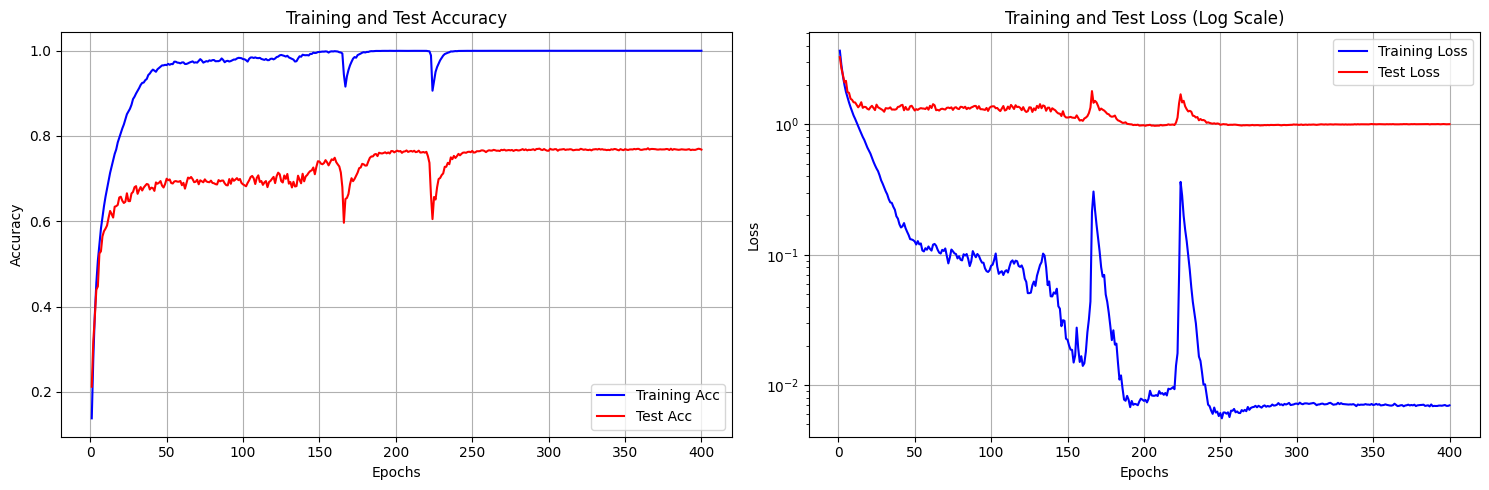

In [299]:
plot_metrics(losses=losses, accuracies=accuracies, val_losses=val_losses, val_accuracies=val_accuracies)


# OOD SCORES

In [300]:
@torch.no_grad()
def extract_features_and_logits(model, dataloader, device):
    model.eval()
    model.to(device)

    all_features = []
    all_logits = []
    all_labels = []

    for images, labels in tqdm(dataloader, desc="Extracting"):
        images = images.to(device)

        features,logits = model(images)

        all_features.append(features.detach().cpu().numpy())
        all_logits.append(logits.detach().cpu().numpy())
        all_labels.append(labels.numpy())

    return (
        np.concatenate(all_features),
        np.concatenate(all_logits),
        np.concatenate(all_labels)
    )

In [301]:
from scipy.special import logsumexp, softmax
from scipy.linalg import pinv
from sklearn.covariance import EmpiricalCovariance
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score

class OODScorer:
    def __init__(self, W, b, num_classes):
        self.W = W
        self.b = b
        self.num_classes = num_classes

    def fit(self, train_features, train_logits, train_labels, vim_dim=64):
        # Mahalanobis Fit
        self.means = np.array([train_features[train_labels == c].mean(axis=0) for c in range(self.num_classes)])
        centered_features = train_features - self.means[train_labels]
        ec = EmpiricalCovariance(assume_centered=True).fit(centered_features)
        self.precision = ec.precision_

        # ViM Fit
        self.u = -pinv(self.W) @ self.b
        X = train_features - self.u
        cov = np.cov(X, rowvar=False)
        eig_vals, eig_vecs = np.linalg.eigh(cov)

        self.residual_subspace = eig_vecs[:, : (X.shape[1] - vim_dim)]

        res_norms = np.linalg.norm(X @ self.residual_subspace, axis=-1)
        self.alpha = np.mean(np.max(train_logits, axis=-1)) / np.mean(res_norms)

    def score(self, features, logits):
        scores = {}

        # 1. MSP
        probs = softmax(logits, axis=1)
        scores['msp'] = np.max(probs, axis=1)

        # 2. MLS
        scores['mls'] = np.max(logits, axis=1)

        # 3. Energy Score
        scores['energy'] = logsumexp(logits, axis=1)

        # 4. Mahalanobis
        maha_scores = []
        for x in features:
            diff = self.means - x
            dists = np.diag(diff @ self.precision @ diff.T)
            maha_scores.append(-np.min(dists))
        scores['mahalanobis'] = np.array(maha_scores)

        # 5. ViM
        X_test = features - self.u
        res_norms = np.linalg.norm(X_test @ self.residual_subspace, axis=-1)
        v_logits = res_norms * self.alpha
        scores['vim'] = scores['energy'] - v_logits

        return scores

In [302]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

def evaluate_ood(id_scores, ood_scores, device=None):

    # Labels: 0 for ID, 1 for OOD
    labels = np.concatenate([np.zeros(len(id_scores)), np.ones(len(ood_scores))])

    # Negate raw NECO scores so that higher values = OOD
    scores = np.concatenate([-id_scores, -ood_scores])

    # AUROC: Standard area under the curve
    auroc = roc_auc_score(labels, scores)

    # AUPR_Out: Precision-Recall area where OOD is positive
    aupr_out = average_precision_score(labels, scores)

    # AUPR_In: Precision-Recall area where ID is Positive
    aupr_in = average_precision_score(1 - labels, -scores)

    # FPR95: False Positive Rate (ID misclassified as OOD)
    fpr, tpr, _ = roc_curve(labels, scores)
    fpr95 = fpr[np.argmax(tpr >= 0.95)]

    return {
        "AUROC": auroc * 100,
        "FPR95": fpr95 * 100,
        "AUPR_In": aupr_in * 100,
        "AUPR_Out": aupr_out * 100
    }

In [321]:
from sklearn.metrics import precision_recall_curve, auc

def plot_comparisons(id_scores_dict, ood_scores_dict, metrics_dict):
    methods = list(id_scores_dict.keys())

    # Rows: Distributions, ROC, PR-In, PR-Out
    fig, axes = plt.subplots(4, len(methods), figsize=(4 * len(methods), 16))
    fig.suptitle("Full OOD Benchmark: ID vs OOD Perspective", fontsize=22, y=1.02)

    for i, method in enumerate(methods):
        id_s = id_scores_dict[method]
        ood_s = ood_scores_dict[method]
        met = metrics_dict[method]

        # Labels for ID-centric (ID=1, OOD=0)
        labels_in = np.concatenate([np.ones(len(id_s)), np.zeros(len(ood_s))])
        scores_in = np.concatenate([id_s, ood_s])

        # Labels for OOD-centric (OOD=1, ID=0)
        labels_out = 1 - labels_in
        scores_out = -scores_in

        # Row 1: Score Distributions
        axes[0, i].hist(id_s, bins=50, alpha=0.5, label='ID', density=True, color='skyblue')
        axes[0, i].hist(ood_s, bins=50, alpha=0.5, label='OOD', density=True, color='salmon')
        axes[0, i].set_title(f"{method.upper()}\nDistributions")
        if i == 0: axes[0, i].legend()

        # Row 2: ROC Curves
        fpr, tpr, _ = roc_curve(labels_out, scores_out)
        axes[1, i].plot(fpr, tpr, color='blue', label=f"AUROC: {met['AUROC']:.3f}")
        axes[1, i].plot([0, 1], [0, 1], 'k--', alpha=0.2)
        axes[1, i].scatter(met['FPR95'], 0.95, color='red', label=f"FPR95: {met['FPR95']:.3f}")
        axes[1, i].set_title("ROC Curve")
        axes[1,i].set_xlabel("FPR")
        axes[1,i].set_ylabel("TPR")
        axes[1,i].set_title(f"{method.upper()} ROC")
        axes[1,i].legend(loc="lower right")

        # Row 3: PR-In (Success/OOD Detection)
        prec_in, rec_in, _ = precision_recall_curve(labels_out, scores_out)
        axes[2, i].plot(rec_in, prec_in, color='green', label=f"AUPR-In: {met['AUPR_In']:.3f}")
        axes[2, i].set_title("PR-In (ID=Pos)")
        axes[2, i].set_xlabel("Recall (ID)")
        axes[2, i].set_ylabel("Precision (ID)")
        axes[2, i].legend(loc="lower left")

        # Row 4: PR-Out (Error/ID Detection)
        prec_out, rec_out, _ = precision_recall_curve(labels_in, scores_in)
        axes[3, i].plot(rec_out, prec_out, color='purple', label=f"AUPR-Out: {met['AUPR_Out']:.3f}")
        axes[3, i].set_title("PR-Out (OOD=Pos)")
        axes[3, i].set_xlabel("Recall (OOD)")
        axes[3, i].set_ylabel("Precision (OOD)")
        axes[3, i].legend(loc="lower left")

    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/metrics/full_ood_benchmark.png", dpi=300)
    plt.show()

In [322]:
# We remove augmentation on train_data for the continuation of our analysis
train_data = torchvision.datasets.CIFAR100(
    root="./data", train=True, download=True, transform=tr
)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

In [323]:
svhn_test = torchvision.datasets.SVHN(root="./data", split="test", download=True, transform = tr)

In [324]:
print(len(val_data),len(svhn_test))

10000 26032


In [325]:
# We want the same number of id and ood for better interpretation of metrics
from torch.utils.data import Subset

N = len(val_data)
g = torch.Generator().manual_seed(42)
indices = indices = torch.randperm(len(svhn_test), generator=g)[:N]
svhn_subset = Subset(svhn_test, indices)

In [326]:
svhn_test_loader = torch.utils.data.DataLoader(svhn_subset, batch_size=batch_size, shuffle=False, num_workers=2)

In [327]:
print("Extracting ID Train Statistics (CIFAR-100)...")
train_features, train_logits, train_labels = extract_features_and_logits(resnet, train_dataloader, device)

print("Extracting ID Test Data (CIFAR-100)...")
id_features, id_logits, _ = extract_features_and_logits(resnet, val_dataloader, device)

print("Extracting OOD Test Data (SVHN)...")
ood_features, ood_logits, _ = extract_features_and_logits(resnet, svhn_test_loader,device)

Extracting ID Train Statistics (CIFAR-100)...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Extracting ID Test Data (CIFAR-100)...


Extracting:   0%|          | 0/79 [00:00<?, ?it/s]

Extracting OOD Test Data (SVHN)...


Extracting:   0%|          | 0/79 [00:00<?, ?it/s]

In [328]:
print("Fitting the OOD Scorer...")
W = resnet.fc.weight.detach().cpu().numpy()
b = resnet.fc.bias.detach().cpu().numpy()
scorer = OODScorer(W, b, num_classes=100)
scorer.fit(train_features, train_logits, train_labels)

print("Calculating Scores...")
id_scores = scorer.score(id_features, id_logits)
ood_scores = scorer.score(ood_features, ood_logits)

print("Evaluating Scores...")
all_metrics_evaluated = {}
for method_name in id_scores.keys():
    current_metrics = evaluate_ood(id_scores[method_name], ood_scores[method_name],device)
    all_metrics_evaluated[method_name] = current_metrics
    print(f"Metrics for {method_name.upper()}: {current_metrics}")

Fitting the OOD Scorer...
Calculating Scores...
Evaluating Scores...
Metrics for MSP: {'AUROC': np.float64(83.552331), 'FPR95': np.float64(48.71), 'AUPR_In': np.float64(86.0554972515308), 'AUPR_Out': np.float64(79.4603293275452)}
Metrics for MLS: {'AUROC': np.float64(84.510163), 'FPR95': np.float64(46.47), 'AUPR_In': np.float64(86.91973978694021), 'AUPR_Out': np.float64(80.30895264165294)}
Metrics for ENERGY: {'AUROC': np.float64(84.999645), 'FPR95': np.float64(46.18), 'AUPR_In': np.float64(87.23230044622065), 'AUPR_Out': np.float64(81.14052092072966)}
Metrics for MAHALANOBIS: {'AUROC': np.float64(87.9962555), 'FPR95': np.float64(45.019999999999996), 'AUPR_In': np.float64(89.04783180476905), 'AUPR_Out': np.float64(86.64103883916616)}
Metrics for VIM: {'AUROC': np.float64(84.38963499999998), 'FPR95': np.float64(41.660000000000004), 'AUPR_In': np.float64(87.87365788482022), 'AUPR_Out': np.float64(76.75557089474444)}


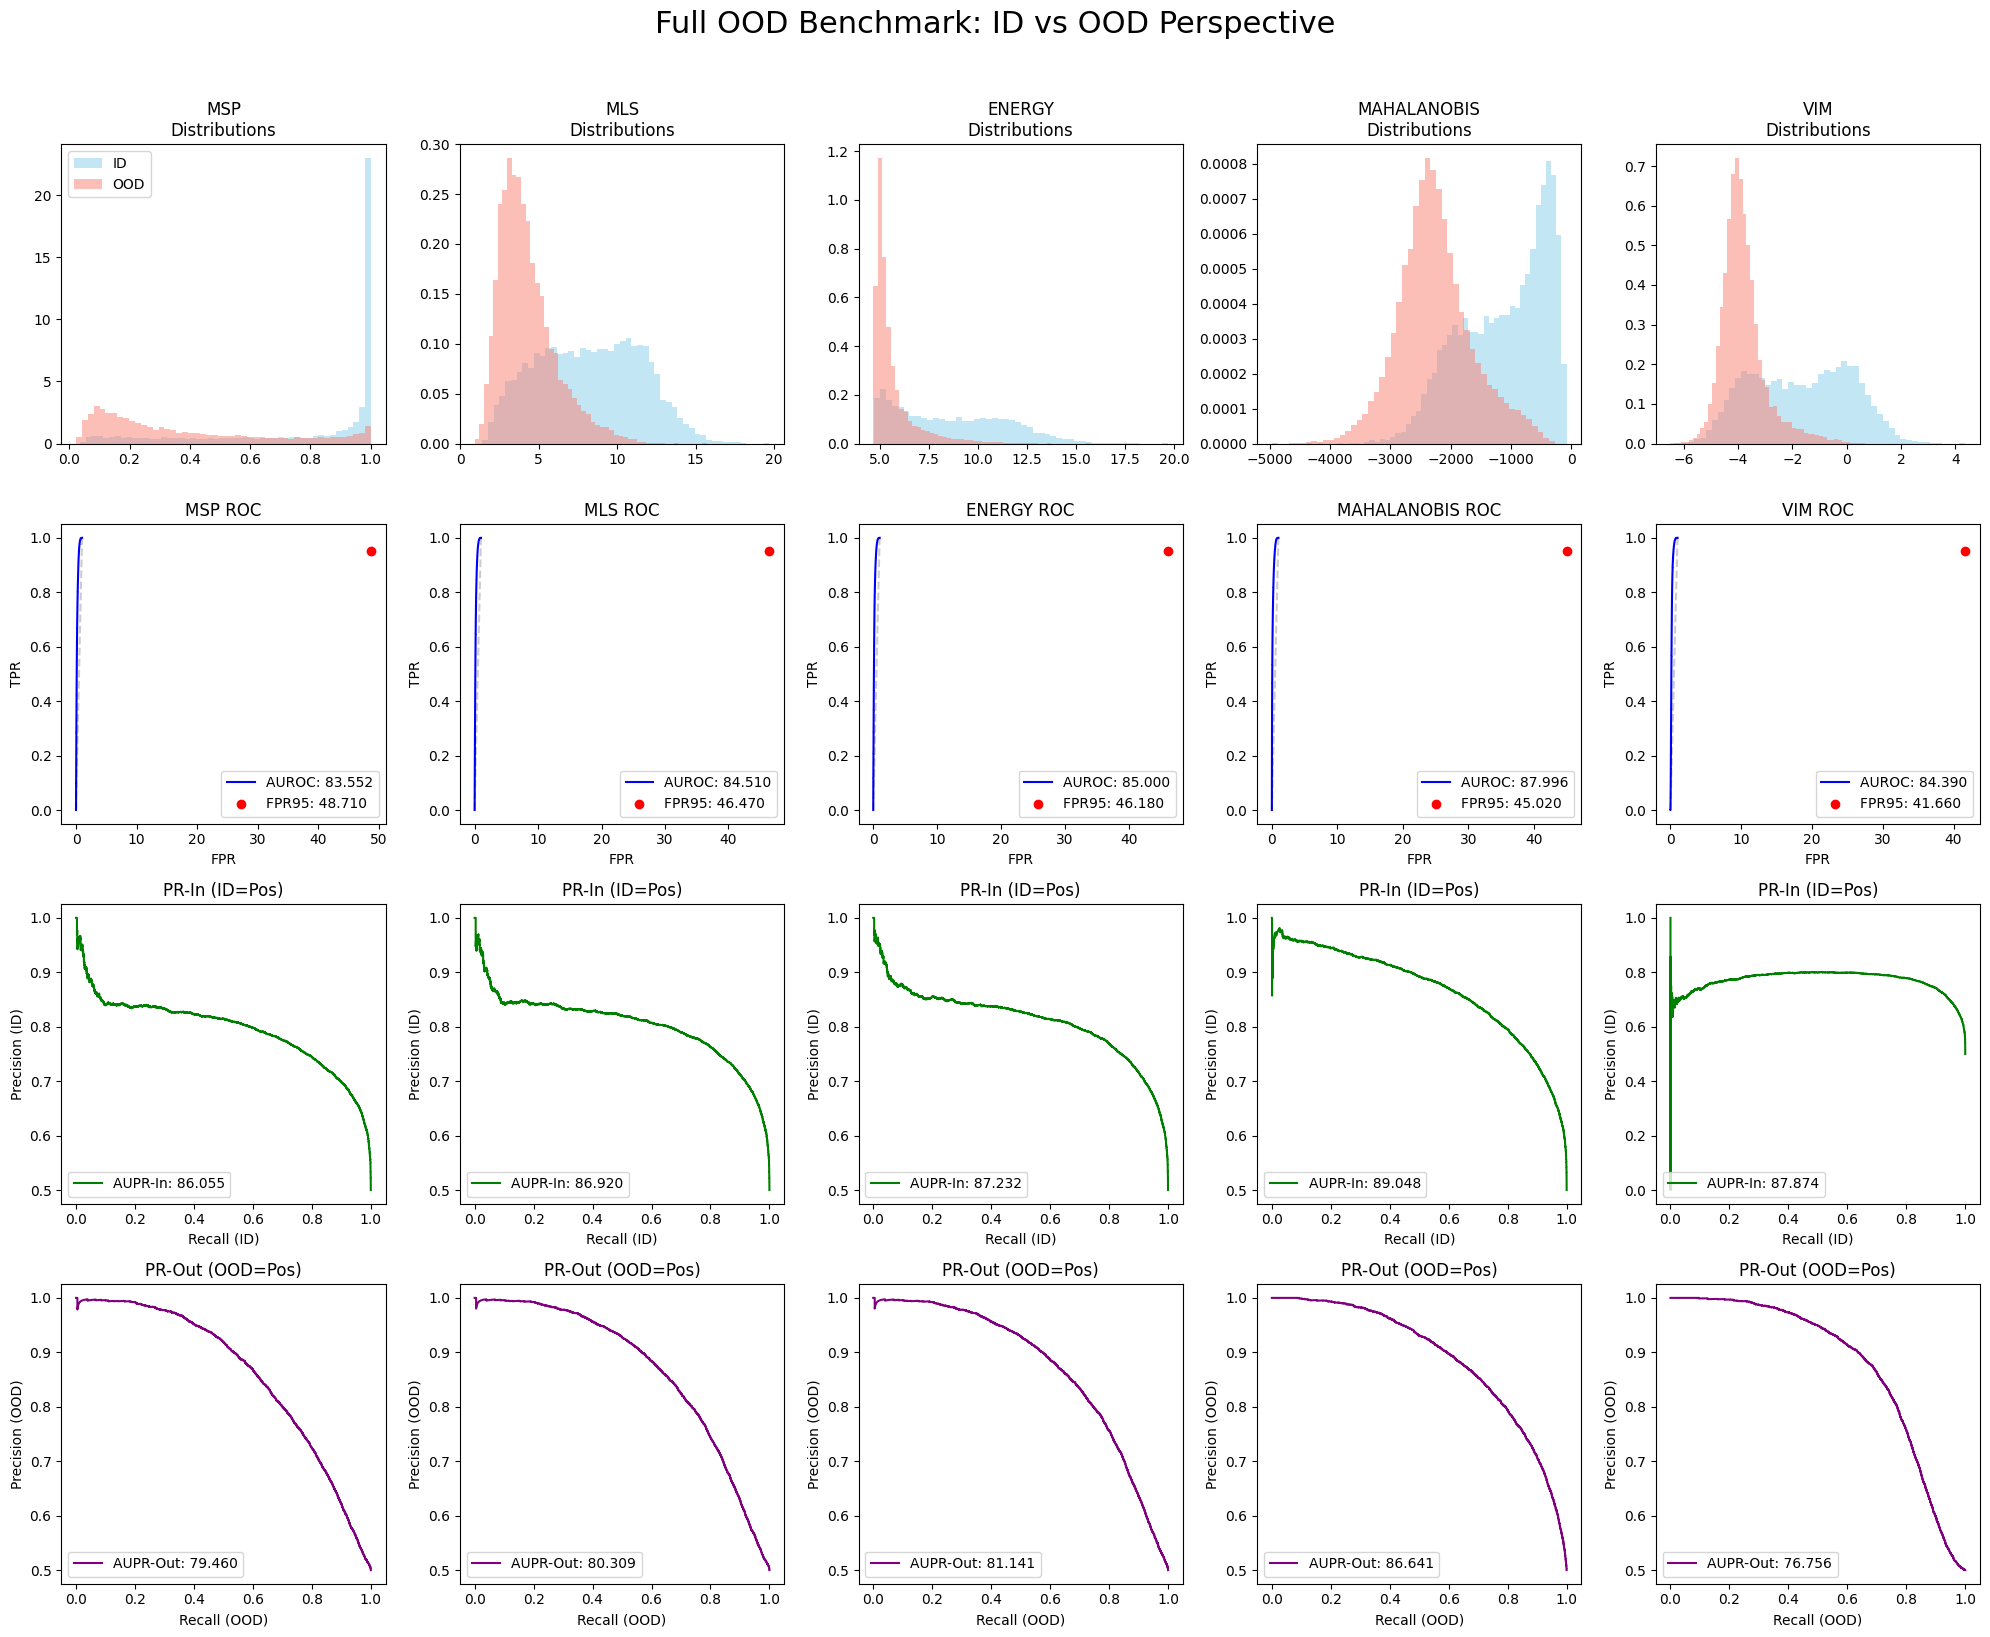

In [329]:
plot_comparisons(id_scores, ood_scores, all_metrics_evaluated)

In [330]:
def save_individual_plots(id_scores_dict, ood_scores_dict, metrics_dict):

    path = f"/content/drive/MyDrive/metrics"
    os.makedirs(path, exist_ok=True)
    methods = list(id_scores_dict.keys())

    for method in methods:

        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle(f"OOD Benchmark: {method.upper()}", fontsize=18)

        id_s = id_scores_dict[method]
        ood_s = ood_scores_dict[method]
        met = metrics_dict[method]

        # Labels for ID-centric (ID=1, OOD=0)
        labels_in = np.concatenate([np.ones(len(id_s)), np.zeros(len(ood_s))])
        scores_in = np.concatenate([id_s, ood_s])

        # Labels for OOD-centric (OOD=1, ID=0)
        labels_out = 1 - labels_in
        scores_out = -scores_in

        # Top Left: Score Distributions
        ax = axes[0, 0]
        ax.hist(id_s, bins=50, alpha=0.5, label='ID', density=True, color='skyblue')
        ax.hist(ood_s, bins=50, alpha=0.5, label='OOD', density=True, color='salmon')
        ax.set_title("Score Distributions")
        ax.legend()

        # Top Right: ROC Curve
        ax = axes[0, 1]
        fpr, tpr, _ = roc_curve(labels_in, scores_in)
        ax.plot(fpr, tpr, color='blue', label=f"AUROC: {met['AUROC']:.3f}")
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.2)
        ax.scatter(met['FPR95'], 0.95, color='red', label=f"FPR95: {met['FPR95']:.3f}")
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_title("ROC Curve")
        ax.legend(loc="lower right")

        # Bottom Left: PR-In (Success/ID Detection)
        ax = axes[1, 0]
        prec_in, rec_in, _ = precision_recall_curve(labels_in, scores_in)
        ax.plot(rec_in, prec_in, color='green', label=f"AUPR-In: {met['AUPR_In']:.3f}")
        ax.set_xlabel("Recall (ID)")
        ax.set_ylabel("Precision (ID)")
        ax.set_title("PR-In (ID = Positive)")
        ax.legend(loc="lower left")

        # Bottom Right: PR-Out (Error/OOD Detection)
        ax = axes[1, 1]
        prec_out, rec_out, _ = precision_recall_curve(labels_out, scores_out)
        ax.plot(rec_out, prec_out, color='purple', label=f"AUPR-Out: {met['AUPR_Out']:.3f}")
        ax.set_xlabel("Recall (OOD)")
        ax.set_ylabel("Precision (OOD)")
        ax.set_title("PR-Out (OOD = Positive)")
        ax.legend(loc="lower left")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Save and close to free up memory
        file_path = os.path.join(path, f"{method.lower()}_analysis.png")
        plt.savefig(file_path, dpi=300)
        plt.close(fig)
        print(f"Saved: {file_path}")

In [136]:
save_individual_plots(id_scores_dict=id_scores, ood_scores_dict=ood_scores, metrics_dict=all_metrics_evaluated)

Saved: /content/drive/MyDrive/metrics/msp_analysis.png
Saved: /content/drive/MyDrive/metrics/mls_analysis.png
Saved: /content/drive/MyDrive/metrics/energy_analysis.png
Saved: /content/drive/MyDrive/metrics/mahalanobis_analysis.png
Saved: /content/drive/MyDrive/metrics/vim_analysis.png


# NC Analysis

Variability collapse : In class variations converges towards 0.
$$
\Sigma_B \to 0
$$
In practice we have
$$
Tr\big [ \frac {\Sigma_W \Sigma_B ^ † } C \big ]
$$ with

- $\Sigma_W$ (Within-class): $\frac{1}{n} \sum_{c=1}^C \sum_{i=1}^{n_c} (h_{i,c} - \mu_c)(h_{i,c} - \mu_c)^\top$
- $\Sigma_B$ (Between-class): $\frac{1}{C} \sum_{c=1}^C (\mu_c - \mu_G)(\mu_c - \mu_G)^\top$


In [353]:
def verify_nc1(features, labels, logits = None):

    N, d = features.shape
    classes = torch.unique(labels)
    C = len(classes)

    # Global mean
    mu_g = features.mean(dim=0, keepdim=True)

    # Initialize Covariance Matrices
    sigma_w = torch.zeros((d, d), device=features.device)
    sigma_b = torch.zeros((d, d), device=features.device)

    for c in classes:
        # Filter features for class c
        h_c = features[labels == c]
        n_c = h_c.shape[0]

        # Compute class mean
        mu_c = h_c.mean(dim=0, keepdim=True)

        # Within-class covariance contribution
        centered_h = h_c - mu_c
        sigma_w += torch.mm(centered_h.t(), centered_h)

        # Between-class covariance contribution
        centered_mu = mu_c - mu_g
        sigma_b += torch.mm(centered_mu.t(), centered_mu)

    # Normalize by N and C
    sigma_w /= N
    sigma_b /= C

    Sigma_B_pinv = torch.linalg.pinv(sigma_b, hermitian=True)
    product = torch.mm(sigma_w, Sigma_B_pinv)
    nc1_val = torch.trace(product) / C
    print(f"NC1 Value: {nc1_val.item()}")
    return nc1_val.item()

In [332]:
# we make sure that we removed augmentation on the train_dataset
print(train_dataloader.dataset.transform)


Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
)


In [333]:
features, logits, labels = extract_features_and_logits(resnet, train_dataloader,device)

Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

In [334]:
id_features, id_logits, id_labels = extract_features_and_logits(resnet, val_dataloader,device)

Extracting:   0%|          | 0/79 [00:00<?, ?it/s]

In [335]:
ood_features, ood_logits, ood_labels = extract_features_and_logits(resnet, svhn_test_loader,device)

Extracting:   0%|          | 0/79 [00:00<?, ?it/s]

In [336]:
nc1 = verify_nc1(torch.from_numpy(features), torch.from_numpy(labels))

NC1 Value: 0.0399792306125164


- The NC1 value is very small. This show that we have reached the terminal phase of training. The clusters have shrunk significantly.


Now we are going to visualize the values of NC 1 across epochs.


In [337]:
def NC_values(num,f_nc):

  nc_values = []
  for i in range(10,401,10):
    print(f'Computing nc{num} value for epoch {i}...')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet1 = ResNet18(num_classes=100).to(device)
    checkpoint_path = f"/content/drive/MyDrive/models/resnet_{i}_epoch.pth"
    checkpoint = torch.load(checkpoint_path, map_location=device)
    resnet1.load_state_dict(checkpoint['model_state_dict'])

    features1, logits1, labels1 = extract_features_and_logits(resnet1, train_dataloader,device)
    if num < 4:
      values = f_nc(torch.from_numpy(features1), torch.from_numpy(labels1))
    elif num == 4:
      values = f_nc(torch.from_numpy(features1), torch.from_numpy(labels1),torch.from_numpy(logits1))

    else:
      values = f_nc(torch.from_numpy(features1), torch.from_numpy(labels1),torch.from_numpy(ood_features))

    nc_values.append(values)

    del resnet1
    torch.cuda.empty_cache()
  return nc_values

def plot_NC(num,nc_values):

  epochs = list(range(10, 401, 10))
  plt.figure(figsize=(10, 6))
  plt.plot(epochs, nc_values, marker='o', linestyle='-', color='#1f77b4', linewidth=2, label='NC Value')

  plt.title(f'Evolution of NC {num} across epochs', fontsize=14)
  plt.xlabel('Epoch', fontsize=12)
  plt.ylabel(f'NC {num}', fontsize=12)
  plt.grid(True, which="both", linestyle='--', alpha=0.5)
  plt.legend()

  # Save the figure to your drive or local environment
  save_path = f"/content/drive/MyDrive/NC/nc{num}_evolution_curve.png"
  os.makedirs(os.path.dirname(save_path), exist_ok=True)
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
  plt.show()

  print(f"Analysis complete. Plot saved at: {save_path}")

In [78]:
nc1_val = NC_values(1,verify_nc1)

Computing nc1 value for epoch 10...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 8.09704303741455
Computing nc1 value for epoch 20...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 4.792046070098877
Computing nc1 value for epoch 30...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 3.4350082874298096
Computing nc1 value for epoch 40...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 2.5678153038024902
Computing nc1 value for epoch 50...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 2.011674404144287
Computing nc1 value for epoch 60...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 1.7232093811035156
Computing nc1 value for epoch 70...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 1.4555253982543945
Computing nc1 value for epoch 80...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 1.2676496505737305
Computing nc1 value for epoch 90...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 1.131923794746399
Computing nc1 value for epoch 100...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.9985666871070862
Computing nc1 value for epoch 110...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.827927827835083
Computing nc1 value for epoch 120...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.7970030307769775
Computing nc1 value for epoch 130...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.7366507649421692
Computing nc1 value for epoch 140...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.6463320255279541
Computing nc1 value for epoch 150...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.4063146114349365
Computing nc1 value for epoch 160...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.295940637588501
Computing nc1 value for epoch 170...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.6233827471733093
Computing nc1 value for epoch 180...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.3702143430709839
Computing nc1 value for epoch 190...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.20681944489479065
Computing nc1 value for epoch 200...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.1561894565820694
Computing nc1 value for epoch 210...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.1236555352807045
Computing nc1 value for epoch 220...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.09980157762765884
Computing nc1 value for epoch 230...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.37361785769462585
Computing nc1 value for epoch 240...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.1672622710466385
Computing nc1 value for epoch 250...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.11434368044137955
Computing nc1 value for epoch 260...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.09472186118364334
Computing nc1 value for epoch 270...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.07967597991228104
Computing nc1 value for epoch 280...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.06975315511226654
Computing nc1 value for epoch 290...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.06134049966931343
Computing nc1 value for epoch 300...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.055250223726034164
Computing nc1 value for epoch 310...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.05136074870824814
Computing nc1 value for epoch 320...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.04805096611380577
Computing nc1 value for epoch 330...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.045597776770591736
Computing nc1 value for epoch 340...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.043630123138427734
Computing nc1 value for epoch 350...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.0422244518995285
Computing nc1 value for epoch 360...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.04132366180419922
Computing nc1 value for epoch 370...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.04061901196837425
Computing nc1 value for epoch 380...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.04060772806406021
Computing nc1 value for epoch 390...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.04061199352145195
Computing nc1 value for epoch 400...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC1 Value: 0.0399792343378067


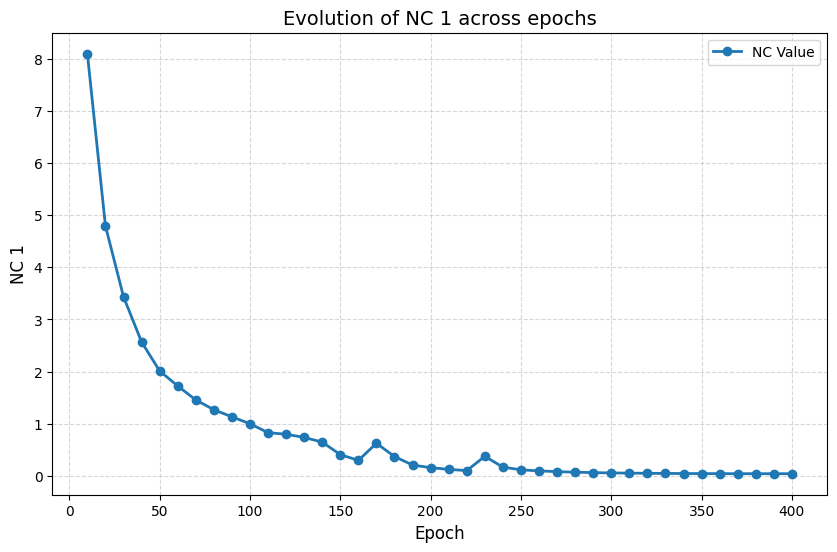

Analysis complete. Plot saved at: /content/drive/MyDrive/NC/nc1_evolution_curve.png


In [81]:
plot_NC(1,nc1_val)

## NC 2

As training progresses, the standard deviations of the cosines approach zero
indicating equiangularity

$$
\left| \|\mu_c - \mu_G\|_2 - \|\mu_{c'} - \mu_G\|_2 \right| \to 0 \quad \forall c, c'
$$
$$
    \langle \tilde{\mu}_c, \tilde{\mu}_{c'} \rangle \to \frac{C}{C-1} \delta_{c,c'} - \frac{1}{C-1} \quad \forall c, c'
$$
In practice we have
$$
EN_{\text{class-means}} = \frac{std_c\{ \|\mu_c - \mu_G\|_2 \}}{avg_c\{ \|\mu_c - \mu_G\|_2 \}} \to 0
$$

and
$$
\text{Equiangularity}_{\text{class-means}} = Avg_{c,c'} \big | \frac{ \langle {\mu}_c-{\mu}_G, {\mu}_{c'} - {\mu}_G \rangle  + \frac 1 {C-1} } {\|\mu_c - \mu_G\|_2\|\mu_c' - \mu_G\|_2}   \big | \to 0
$$

In [338]:
def verify_nc2(features, labels, logits = None):

    classes = torch.unique(labels)
    C = len(classes)

    class_means = torch.stack([
        features[labels == c].mean(0) for c in classes
    ])

    mu_G = features.mean(0)
    centered_means = class_means - mu_G

    norms = torch.norm(centered_means, dim=1)

    # Equinormality
    en_val = torch.std(norms, unbiased=False) / torch.mean(norms)

    # Equiangularity
    eps = 1e-12
    normed_means = centered_means / (norms.view(-1, 1) + eps)
    cos_sim_matrix = torch.mm(normed_means, normed_means.t())

    mask = ~torch.eye(C, dtype=torch.bool, device=features.device)
    off_diag_cos = cos_sim_matrix[mask]

    ideal_cos = -1.0 / (C - 1)
    equiangularity_val = torch.abs(off_diag_cos - ideal_cos).mean()
    print(f'Equiangularity: {equiangularity_val.item()}')
    print(f'Equinormormality : {en_val.item()}')

    return en_val.item(), equiangularity_val.item()


In [339]:
results = verify_nc2(torch.from_numpy(features), torch.from_numpy(labels))

Equiangularity: 0.05180078372359276
Equinormormality : 0.02868789993226528


As expected, the values are very small. This validate the NC2 property.

Now we will visualize these values across different epochs and we will look at the cosine similarity heatmap and the distributions of pairwise angles.

In [85]:
nc2_val = NC_values(2,verify_nc2)

Computing nc2 value for epoch 10...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.20071707665920258
Equinormormality : 0.21842975914478302
Computing nc2 value for epoch 20...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.1653045415878296
Equinormormality : 0.1899910271167755
Computing nc2 value for epoch 30...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.14201252162456512
Equinormormality : 0.14524617791175842
Computing nc2 value for epoch 40...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.12180200219154358
Equinormormality : 0.12757359445095062
Computing nc2 value for epoch 50...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.12137594074010849
Equinormormality : 0.11218806356191635
Computing nc2 value for epoch 60...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.11141229420900345
Equinormormality : 0.12423976510763168
Computing nc2 value for epoch 70...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.10456053167581558
Equinormormality : 0.10631834715604782
Computing nc2 value for epoch 80...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.10182970762252808
Equinormormality : 0.09642434120178223
Computing nc2 value for epoch 90...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.09838791936635971
Equinormormality : 0.0998871773481369
Computing nc2 value for epoch 100...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.09587213397026062
Equinormormality : 0.10655538737773895
Computing nc2 value for epoch 110...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.08647485077381134
Equinormormality : 0.10482863336801529
Computing nc2 value for epoch 120...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.08721888810396194
Equinormormality : 0.09898266196250916
Computing nc2 value for epoch 130...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.08598726987838745
Equinormormality : 0.12217102199792862
Computing nc2 value for epoch 140...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.07956315577030182
Equinormormality : 0.10732925683259964
Computing nc2 value for epoch 150...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.0701683983206749
Equinormormality : 0.07488933950662613
Computing nc2 value for epoch 160...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.06472484767436981
Equinormormality : 0.06604835391044617
Computing nc2 value for epoch 170...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.08394913375377655
Equinormormality : 0.12025505304336548
Computing nc2 value for epoch 180...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.06840125471353531
Equinormormality : 0.07539377361536026
Computing nc2 value for epoch 190...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.06045621633529663
Equinormormality : 0.049868144094944
Computing nc2 value for epoch 200...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.05864495784044266
Equinormormality : 0.05485592409968376
Computing nc2 value for epoch 210...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.05744851380586624
Equinormormality : 0.051119498908519745
Computing nc2 value for epoch 220...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.056292738765478134
Equinormormality : 0.04845393821597099
Computing nc2 value for epoch 230...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.07002319395542145
Equinormormality : 0.09849204868078232
Computing nc2 value for epoch 240...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.05702615901827812
Equinormormality : 0.06165757030248642
Computing nc2 value for epoch 250...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.05494453012943268
Equinormormality : 0.03900115564465523
Computing nc2 value for epoch 260...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.05424833670258522
Equinormormality : 0.039780646562576294
Computing nc2 value for epoch 270...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.053655415773391724
Equinormormality : 0.03772960230708122
Computing nc2 value for epoch 280...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.05336899310350418
Equinormormality : 0.041810955852270126
Computing nc2 value for epoch 290...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.0529252365231514
Equinormormality : 0.03528653085231781
Computing nc2 value for epoch 300...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.052599381655454636
Equinormormality : 0.03409287706017494
Computing nc2 value for epoch 310...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.05246271193027496
Equinormormality : 0.036653902381658554
Computing nc2 value for epoch 320...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.0523393340408802
Equinormormality : 0.033820100128650665
Computing nc2 value for epoch 330...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.05221804976463318
Equinormormality : 0.031201323494315147
Computing nc2 value for epoch 340...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.05206652730703354
Equinormormality : 0.03370361402630806
Computing nc2 value for epoch 350...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.05202285945415497
Equinormormality : 0.03313446044921875
Computing nc2 value for epoch 360...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.05189814418554306
Equinormormality : 0.03255166485905647
Computing nc2 value for epoch 370...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.05200394615530968
Equinormormality : 0.033907450735569
Computing nc2 value for epoch 380...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.05190225690603256
Equinormormality : 0.032131295651197433
Computing nc2 value for epoch 390...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.05190231651067734
Equinormormality : 0.03106296993792057
Computing nc2 value for epoch 400...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

Equiangularity: 0.05180078372359276
Equinormormality : 0.02868792414665222


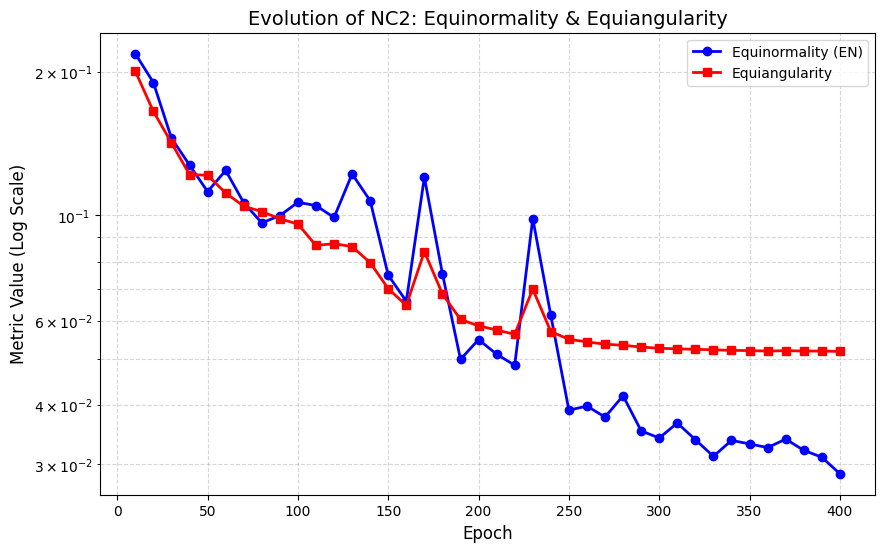

NC2 plot saved to /content/drive/MyDrive/NC/nc2_evolution_curve.png


In [87]:
en_values = [item[0] for item in nc2_val]
equi_values = [item[1] for item in nc2_val]
epochs = list(range(10, 401, 10))

plt.figure(figsize=(10, 6))

# Plot Equinormality
plt.plot(epochs, en_values, marker='o', linestyle='-', color='blue', linewidth=2, label='Equinormality (EN)')

# Plot Equiangularity
plt.plot(epochs, equi_values, marker='s', linestyle='-', color='red', linewidth=2, label='Equiangularity')

plt.yscale('log')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Metric Value (Log Scale)', fontsize=12)
plt.title('Evolution of NC2: Equinormality & Equiangularity', fontsize=14)

plt.grid(True, which="both", linestyle='--', alpha=0.5)
plt.legend()

# 4. Save and Show
save_path = f"/content/drive/MyDrive/NC/nc2_evolution_curve.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"NC2 plot saved to {save_path}")

Heatmap for NC2

In [340]:
import seaborn as sns

def plot_nc2_diagnostics(features, labels):
    # Centered and Normalized Means
    classes = torch.unique(labels)
    C = len(classes)
    class_means = torch.stack([features[labels == c].mean(0) for c in classes])
    centered_means = class_means - features.mean(0)

    # Cosine Similarity Matrix
    normed_means = centered_means / (torch.norm(centered_means, dim=1, keepdim=True) + 1e-12)
    cos_sim = (normed_means @ normed_means.T).cpu().numpy()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # Subplot 1: Heatmap
    sns.heatmap(cos_sim, cmap='coolwarm', center=0, vmin=-0.1, vmax=1.0, ax=ax1)
    ax1.set_title(f"Cosine Similarity Heatmap")
    ax1.set_xlabel("Class Index")
    ax1.set_ylabel("Class Index")

    # Subplot 2: Histogram of Off-Diagonal elements
    mask = ~np.eye(C, dtype=bool)
    off_diag = cos_sim[mask]

    ax2.hist(off_diag, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
    ideal_val = -1.0 / (C - 1)
    ax2.axvline(ideal_val, color='red', linestyle='--', linewidth=2, label=f'Ideal: {ideal_val:.4f}')

    ax2.set_title(f"Distribution of Pairwise Angles")
    ax2.set_xlabel("Cosine Similarity")
    ax2.set_ylabel("Frequency")
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    save_path = f"/content/drive/MyDrive/NC/nc2_diagnostics_epoch.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

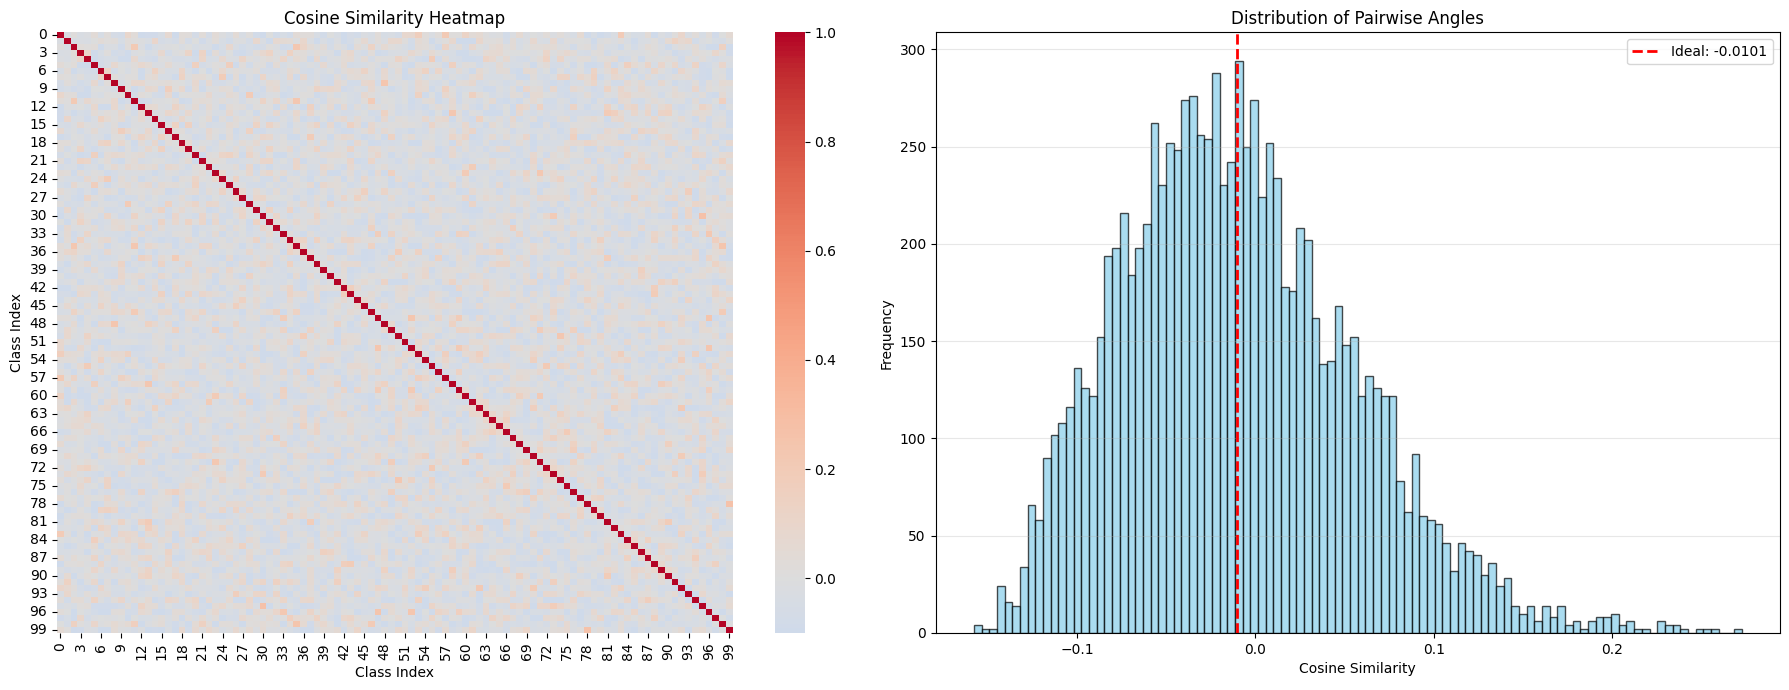

In [97]:
plot_nc2_diagnostics(torch.from_numpy(features), torch.from_numpy(labels))

## NC3
This is the cnvergence to self-duality property:

$$ \left\| \frac{W^T}{\|W|_F} - \frac{\dot M}{\|\dot M|_F}\right\|_F \to 0$$

In [352]:
def verify_nc3(features, labels, logits = None):

    C = len(torch.unique(labels))
    classifier_weights = resnet.fc.weight.detach().cpu()

    # Centered Class Means
    class_means = torch.stack([features[labels == c].mean(0) for c in range(C)])
    mu_G = features.mean(0)
    centered_means = class_means - mu_G

    eps = 1e-12
    # Normalize both weights and centered means
    norm_w = classifier_weights / (torch.norm(classifier_weights, dim=1, keepdim=True) + eps)
    norm_m = centered_means / (torch.norm(centered_means, dim=1, keepdim=True) + eps)

    # Compute L2 distance between normalized vectors
    alignment_dist = torch.norm(norm_w - norm_m, dim=1).mean()
    print(f"NC3 Value: {alignment_dist.item()}")
    return alignment_dist.item()

In [342]:
nc3_deviation = verify_nc3(torch.from_numpy(features), torch.from_numpy(labels))

NC3 Value: 0.17562919855117798


The value of NC3 is small but not that small as NC3 must go to 0. Maybe we needed to train for more epochs. We will plot values of NC3 across epochs to confirm this hypothesis.

In [108]:
nc3_val = NC_values(3,verify_nc3)

Computing nc3 value for epoch 10...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.8144322037696838
Computing nc3 value for epoch 20...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.6961454153060913
Computing nc3 value for epoch 30...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.6109179258346558
Computing nc3 value for epoch 40...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.535183310508728
Computing nc3 value for epoch 50...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.4894460439682007
Computing nc3 value for epoch 60...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.45356854796409607
Computing nc3 value for epoch 70...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.4116455316543579
Computing nc3 value for epoch 80...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.388172447681427
Computing nc3 value for epoch 90...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.3691564202308655
Computing nc3 value for epoch 100...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.34566938877105713
Computing nc3 value for epoch 110...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.3086283206939697
Computing nc3 value for epoch 120...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.30866652727127075
Computing nc3 value for epoch 130...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.306366503238678
Computing nc3 value for epoch 140...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.2662649154663086
Computing nc3 value for epoch 150...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.19741584360599518
Computing nc3 value for epoch 160...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.1679813265800476
Computing nc3 value for epoch 170...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.3038599491119385
Computing nc3 value for epoch 180...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.20349283516407013
Computing nc3 value for epoch 190...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.1532747894525528
Computing nc3 value for epoch 200...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.14580747485160828
Computing nc3 value for epoch 210...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.14586549997329712
Computing nc3 value for epoch 220...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.14738917350769043
Computing nc3 value for epoch 230...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.23754751682281494
Computing nc3 value for epoch 240...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.1723308116197586
Computing nc3 value for epoch 250...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.16078218817710876
Computing nc3 value for epoch 260...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.16127032041549683
Computing nc3 value for epoch 270...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.16283603012561798
Computing nc3 value for epoch 280...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.16434049606323242
Computing nc3 value for epoch 290...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.1666935682296753
Computing nc3 value for epoch 300...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.16936901211738586
Computing nc3 value for epoch 310...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.17007699608802795
Computing nc3 value for epoch 320...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.1714942902326584
Computing nc3 value for epoch 330...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.1728854924440384
Computing nc3 value for epoch 340...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.1740134209394455
Computing nc3 value for epoch 350...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.17420238256454468
Computing nc3 value for epoch 360...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.1746194213628769
Computing nc3 value for epoch 370...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.17549659311771393
Computing nc3 value for epoch 380...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.17590487003326416
Computing nc3 value for epoch 390...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.1757023185491562
Computing nc3 value for epoch 400...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC3 Value: 0.17562919855117798


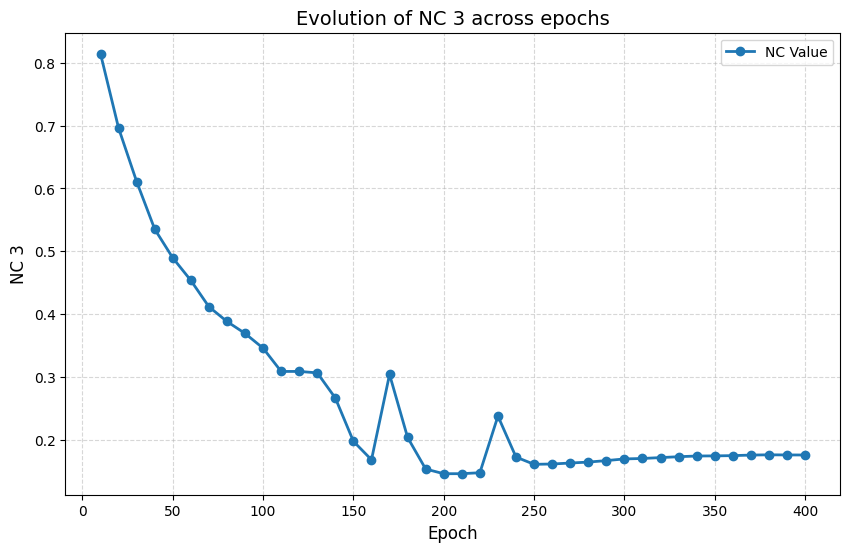

Analysis complete. Plot saved at: /content/drive/MyDrive/NC/nc3_evolution_curve.png


In [109]:
plot_NC(3,nc3_val)

## NC 4
Simplification to NCC
$$ arg\max_{c'} \left< w_{c'}, h \right> + b_{c'} \to \arg\min_{c'} \|h - \mu_{c'}\|_2 $$

The NC4 Metric measures the "disagreement" between the actual model predictions and the NCM predictions. As collapse occurs, we have : $$NC4 = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1} \left( \text{model}(x_i) \neq \arg\min_c \|h(x_i) - \mu_c\|_2 \right) \to 0$$

In [343]:
def verify_nc4(features,labels,logits = None):

    features = torch.as_tensor(features)
    logits = torch.as_tensor(logits)
    labels = torch.as_tensor(labels)

    classes = torch.unique(labels)
    C = len(classes)

    # Class means
    class_means = torch.stack([
        features[labels == c].mean(0)
        for c in classes
    ])

    # Model predictions
    model_preds = torch.argmax(logits, dim=1)

    # NCM predictions
    dist_matrix = torch.cdist(features, class_means)
    ncm_preds = torch.argmin(dist_matrix, dim=1)

    # Disagreement rate
    disagreement = (model_preds != ncm_preds).float().mean()
    print(f"NC4 Value: {disagreement.item()}")
    return disagreement.item()

In [344]:
agr = verify_nc4(features,labels,logits)

NC4 Value: 7.999999797903001e-05


As expected, the NC4 value is very small. This validates property NC4.

Now we observe the evolution of NC4 values across epochs.

In [132]:
nc4_val = NC_values(4,verify_nc4)

Computing nc4 value for epoch 10...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.2985000014305115
Computing nc4 value for epoch 20...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.18831999599933624
Computing nc4 value for epoch 30...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.11327999830245972
Computing nc4 value for epoch 40...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.06942000240087509
Computing nc4 value for epoch 50...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.03751999884843826
Computing nc4 value for epoch 60...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.03751999884843826
Computing nc4 value for epoch 70...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.023000000044703484
Computing nc4 value for epoch 80...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.02459999918937683
Computing nc4 value for epoch 90...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.02672000043094158
Computing nc4 value for epoch 100...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.019579999148845673
Computing nc4 value for epoch 110...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.013260000385344028
Computing nc4 value for epoch 120...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.0142000000923872
Computing nc4 value for epoch 130...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.022579999640583992
Computing nc4 value for epoch 140...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.012959999963641167
Computing nc4 value for epoch 150...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.0006799999973736703
Computing nc4 value for epoch 160...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.00033999999868683517
Computing nc4 value for epoch 170...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.026319999247789383
Computing nc4 value for epoch 180...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.0014199999859556556
Computing nc4 value for epoch 190...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 9.999999747378752e-05
Computing nc4 value for epoch 200...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 7.999999797903001e-05
Computing nc4 value for epoch 210...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 3.9999998989515007e-05
Computing nc4 value for epoch 220...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.00011999999696854502
Computing nc4 value for epoch 230...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.008860000409185886
Computing nc4 value for epoch 240...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.0005000000237487257
Computing nc4 value for epoch 250...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 5.999999848427251e-05
Computing nc4 value for epoch 260...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 1.9999999494757503e-05
Computing nc4 value for epoch 270...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 3.9999998989515007e-05
Computing nc4 value for epoch 280...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 1.9999999494757503e-05
Computing nc4 value for epoch 290...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 3.9999998989515007e-05
Computing nc4 value for epoch 300...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.00011999999696854502
Computing nc4 value for epoch 310...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 3.9999998989515007e-05
Computing nc4 value for epoch 320...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.0
Computing nc4 value for epoch 330...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 7.999999797903001e-05
Computing nc4 value for epoch 340...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 7.999999797903001e-05
Computing nc4 value for epoch 350...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 7.999999797903001e-05
Computing nc4 value for epoch 360...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.00011999999696854502
Computing nc4 value for epoch 370...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.0
Computing nc4 value for epoch 380...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 3.9999998989515007e-05
Computing nc4 value for epoch 390...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 0.00015999999595806003
Computing nc4 value for epoch 400...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC4 Value: 7.999999797903001e-05


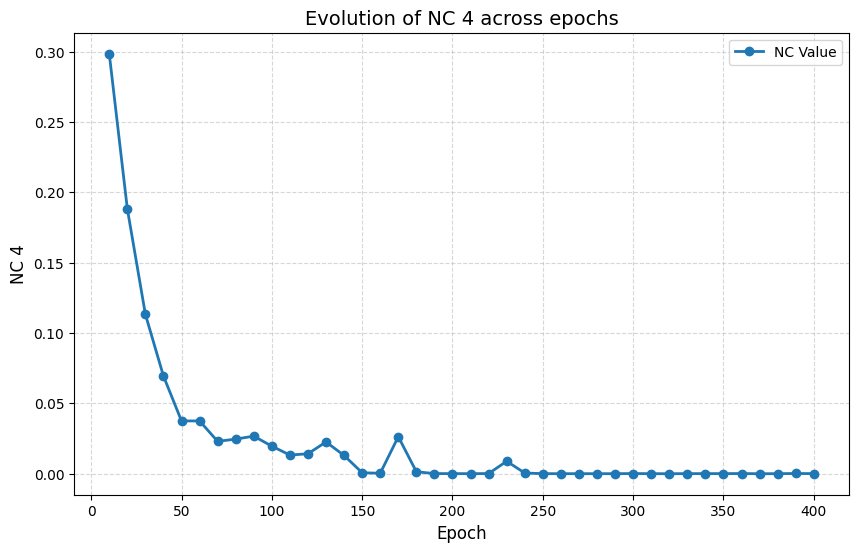

Analysis complete. Plot saved at: /content/drive/MyDrive/NC/nc4_evolution_curve.png


In [133]:
plot_NC(4,nc4_val)

## NC 5

As training progresses, the clusters of OOD become increasingly orthgonal to the ETF subspace of the ID data. We have

$$
\text{OrthoDev}_\text{classes−OOD} = \text{Avg}_c \big | \frac{ \langle {\mu}_c, {\mu}_{G}^{OOD} \rangle } {\|\mu_c  \|_2\| {\mu}_{G}^{OOD} \|_2}     \big | \to 0
$$

In [345]:
def verify_nc5(id_features, id_labels, ood_features):

    id_features = torch.as_tensor(id_features)
    ood_features = torch.as_tensor(ood_features)
    id_labels = torch.as_tensor(id_labels)

    classes = torch.unique(id_labels)
    C = len(classes)

    # ID Class Means (mu_c)
    id_global_mean = id_features.mean(0)
    mu_c = torch.stack([id_features[id_labels == c].mean(0) - id_global_mean for c in classes])

    # OOD Global Mean (mu_G_OOD)
    mu_G_ood = ood_features.mean(0) - id_global_mean

    # Normalize for Cosine Similarity
    mu_c_norm = mu_c / (torch.norm(mu_c, dim=1, keepdim=True) + 1e-12)
    mu_G_ood_norm = mu_G_ood / (torch.norm(mu_G_ood) + 1e-12)

    # Average Absolute Cosine Similarity
    cos_sims = torch.mv(mu_c_norm, mu_G_ood_norm)
    ortho_dev = torch.abs(cos_sims).mean()
    print(f"NC5: {ortho_dev.item()}")
    return ortho_dev.item()

In [346]:
nc5 = verify_nc5(features,labels,ood_features)

NC5: 0.08895241469144821


As expected, the NC5 value is very small and this validates the property NC5. We will then look at the evolution of NC5 values across epochs.

In [154]:
nc5_val = NC_values(5,verify_nc5)

Computing nc5 value for epoch 10...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.10884253680706024
Computing nc5 value for epoch 20...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.07400579750537872
Computing nc5 value for epoch 30...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.06271036714315414
Computing nc5 value for epoch 40...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.07281726598739624
Computing nc5 value for epoch 50...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08031661063432693
Computing nc5 value for epoch 60...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08913854509592056
Computing nc5 value for epoch 70...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.07944221794605255
Computing nc5 value for epoch 80...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.0859522596001625
Computing nc5 value for epoch 90...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08587165921926498
Computing nc5 value for epoch 100...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08124923706054688
Computing nc5 value for epoch 110...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08061446249485016
Computing nc5 value for epoch 120...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08330824971199036
Computing nc5 value for epoch 130...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.09197647124528885
Computing nc5 value for epoch 140...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.0847611054778099
Computing nc5 value for epoch 150...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08386243134737015
Computing nc5 value for epoch 160...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08337210863828659
Computing nc5 value for epoch 170...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08675789833068848
Computing nc5 value for epoch 180...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08480875194072723
Computing nc5 value for epoch 190...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.0835842490196228
Computing nc5 value for epoch 200...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08662472665309906
Computing nc5 value for epoch 210...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08859708905220032
Computing nc5 value for epoch 220...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08910224586725235
Computing nc5 value for epoch 230...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.09373334795236588
Computing nc5 value for epoch 240...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08384983986616135
Computing nc5 value for epoch 250...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08736637234687805
Computing nc5 value for epoch 260...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08613763004541397
Computing nc5 value for epoch 270...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.0881778746843338
Computing nc5 value for epoch 280...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08931337296962738
Computing nc5 value for epoch 290...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08817443996667862
Computing nc5 value for epoch 300...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.0874469056725502
Computing nc5 value for epoch 310...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08959391713142395
Computing nc5 value for epoch 320...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08896266669034958
Computing nc5 value for epoch 330...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08955594152212143
Computing nc5 value for epoch 340...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08947372436523438
Computing nc5 value for epoch 350...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08930324763059616
Computing nc5 value for epoch 360...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.09057492017745972
Computing nc5 value for epoch 370...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08837202936410904
Computing nc5 value for epoch 380...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08840673416852951
Computing nc5 value for epoch 390...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08769365400075912
Computing nc5 value for epoch 400...


Extracting:   0%|          | 0/391 [00:00<?, ?it/s]

NC5: 0.08895241469144821


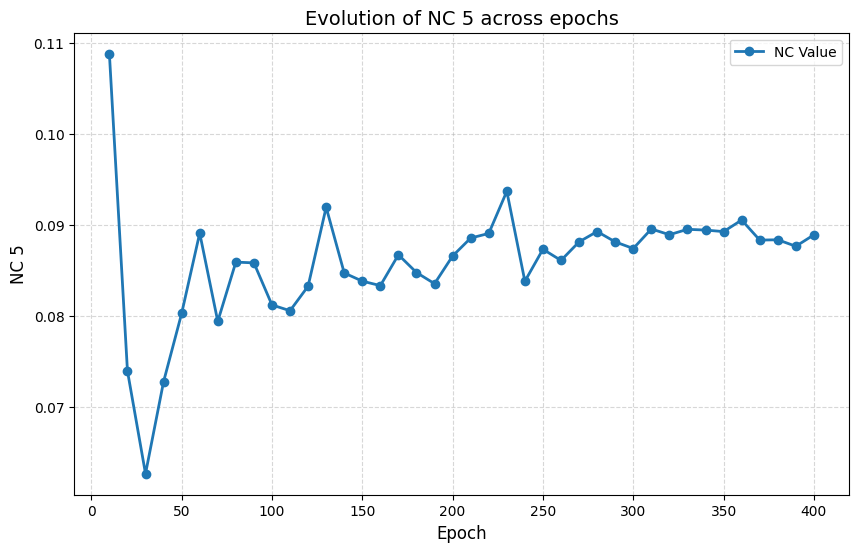

Analysis complete. Plot saved at: /content/drive/MyDrive/NC/nc5_evolution_curve.png


In [155]:
plot_NC(5,nc5_val)

The value of NC5 goes to 0 but seems to stabilize around 0.088 when the number of epochs increases.
This can be explain by the fact that the OOD datasets might share low-level features (textures, edges) with ID classes, creating a "floor" for how low the NC5 can go.

## NECO

The objective is to use a score-based strategy to find OOD detection.

We will implement NECO scores and compare it to previous OOD scores.
Here is the formula of NECO score.

$$\text{NECO}(x) = \frac{\|P h_{\omega}(x)\|}{\|h_{\omega}(x)\|}$$
- $h_{\omega}(x)$: The raw feature vector of an input $x$. In your code, this is often called x_features.
- $P$: The Orthogonal Projection Operator. This projects the feature vector onto the subspace spanned by the training class means.

In [347]:
from sklearn.decomposition import PCA

def neco_scores(test_features,train_features):

    test_features = torch.as_tensor(test_features)
    train_features = torch.as_tensor(train_features)
    num_classes = 100
    pca_model = PCA(n_components= num_classes - 1)
    pca_model.fit(train_features.cpu().numpy())

    x_feat = test_features

    etf_x_feat = pca_model.transform(x_feat) @ pca_model.components_

    numerator = np.linalg.norm(etf_x_feat, axis=1)
    denominator = np.linalg.norm(x_feat, axis=1)

    score = numerator / (denominator + 1e-12)
    print(score)
    return score

In [348]:
neco_id = neco_scores(features,ood_features)
neco_ood = neco_scores(ood_features,ood_features)

[0.90488698 0.9309562  0.90078758 ... 0.92911598 0.92726582 0.89552616]
[0.62211533 0.58171087 0.5991058  ... 0.62735826 0.73631238 0.62639391]


In [349]:
met = evaluate_ood(neco_id,neco_ood)
met

{'AUROC': np.float64(99.65361180000001),
 'FPR95': np.float64(1.778),
 'AUPR_In': np.float64(99.92424933503625),
 'AUPR_Out': np.float64(98.75246198723171)}

In [350]:
id_scores['neco'] = neco_id
ood_scores['neco'] = neco_ood
all_metrics_evaluated['neco'] = met

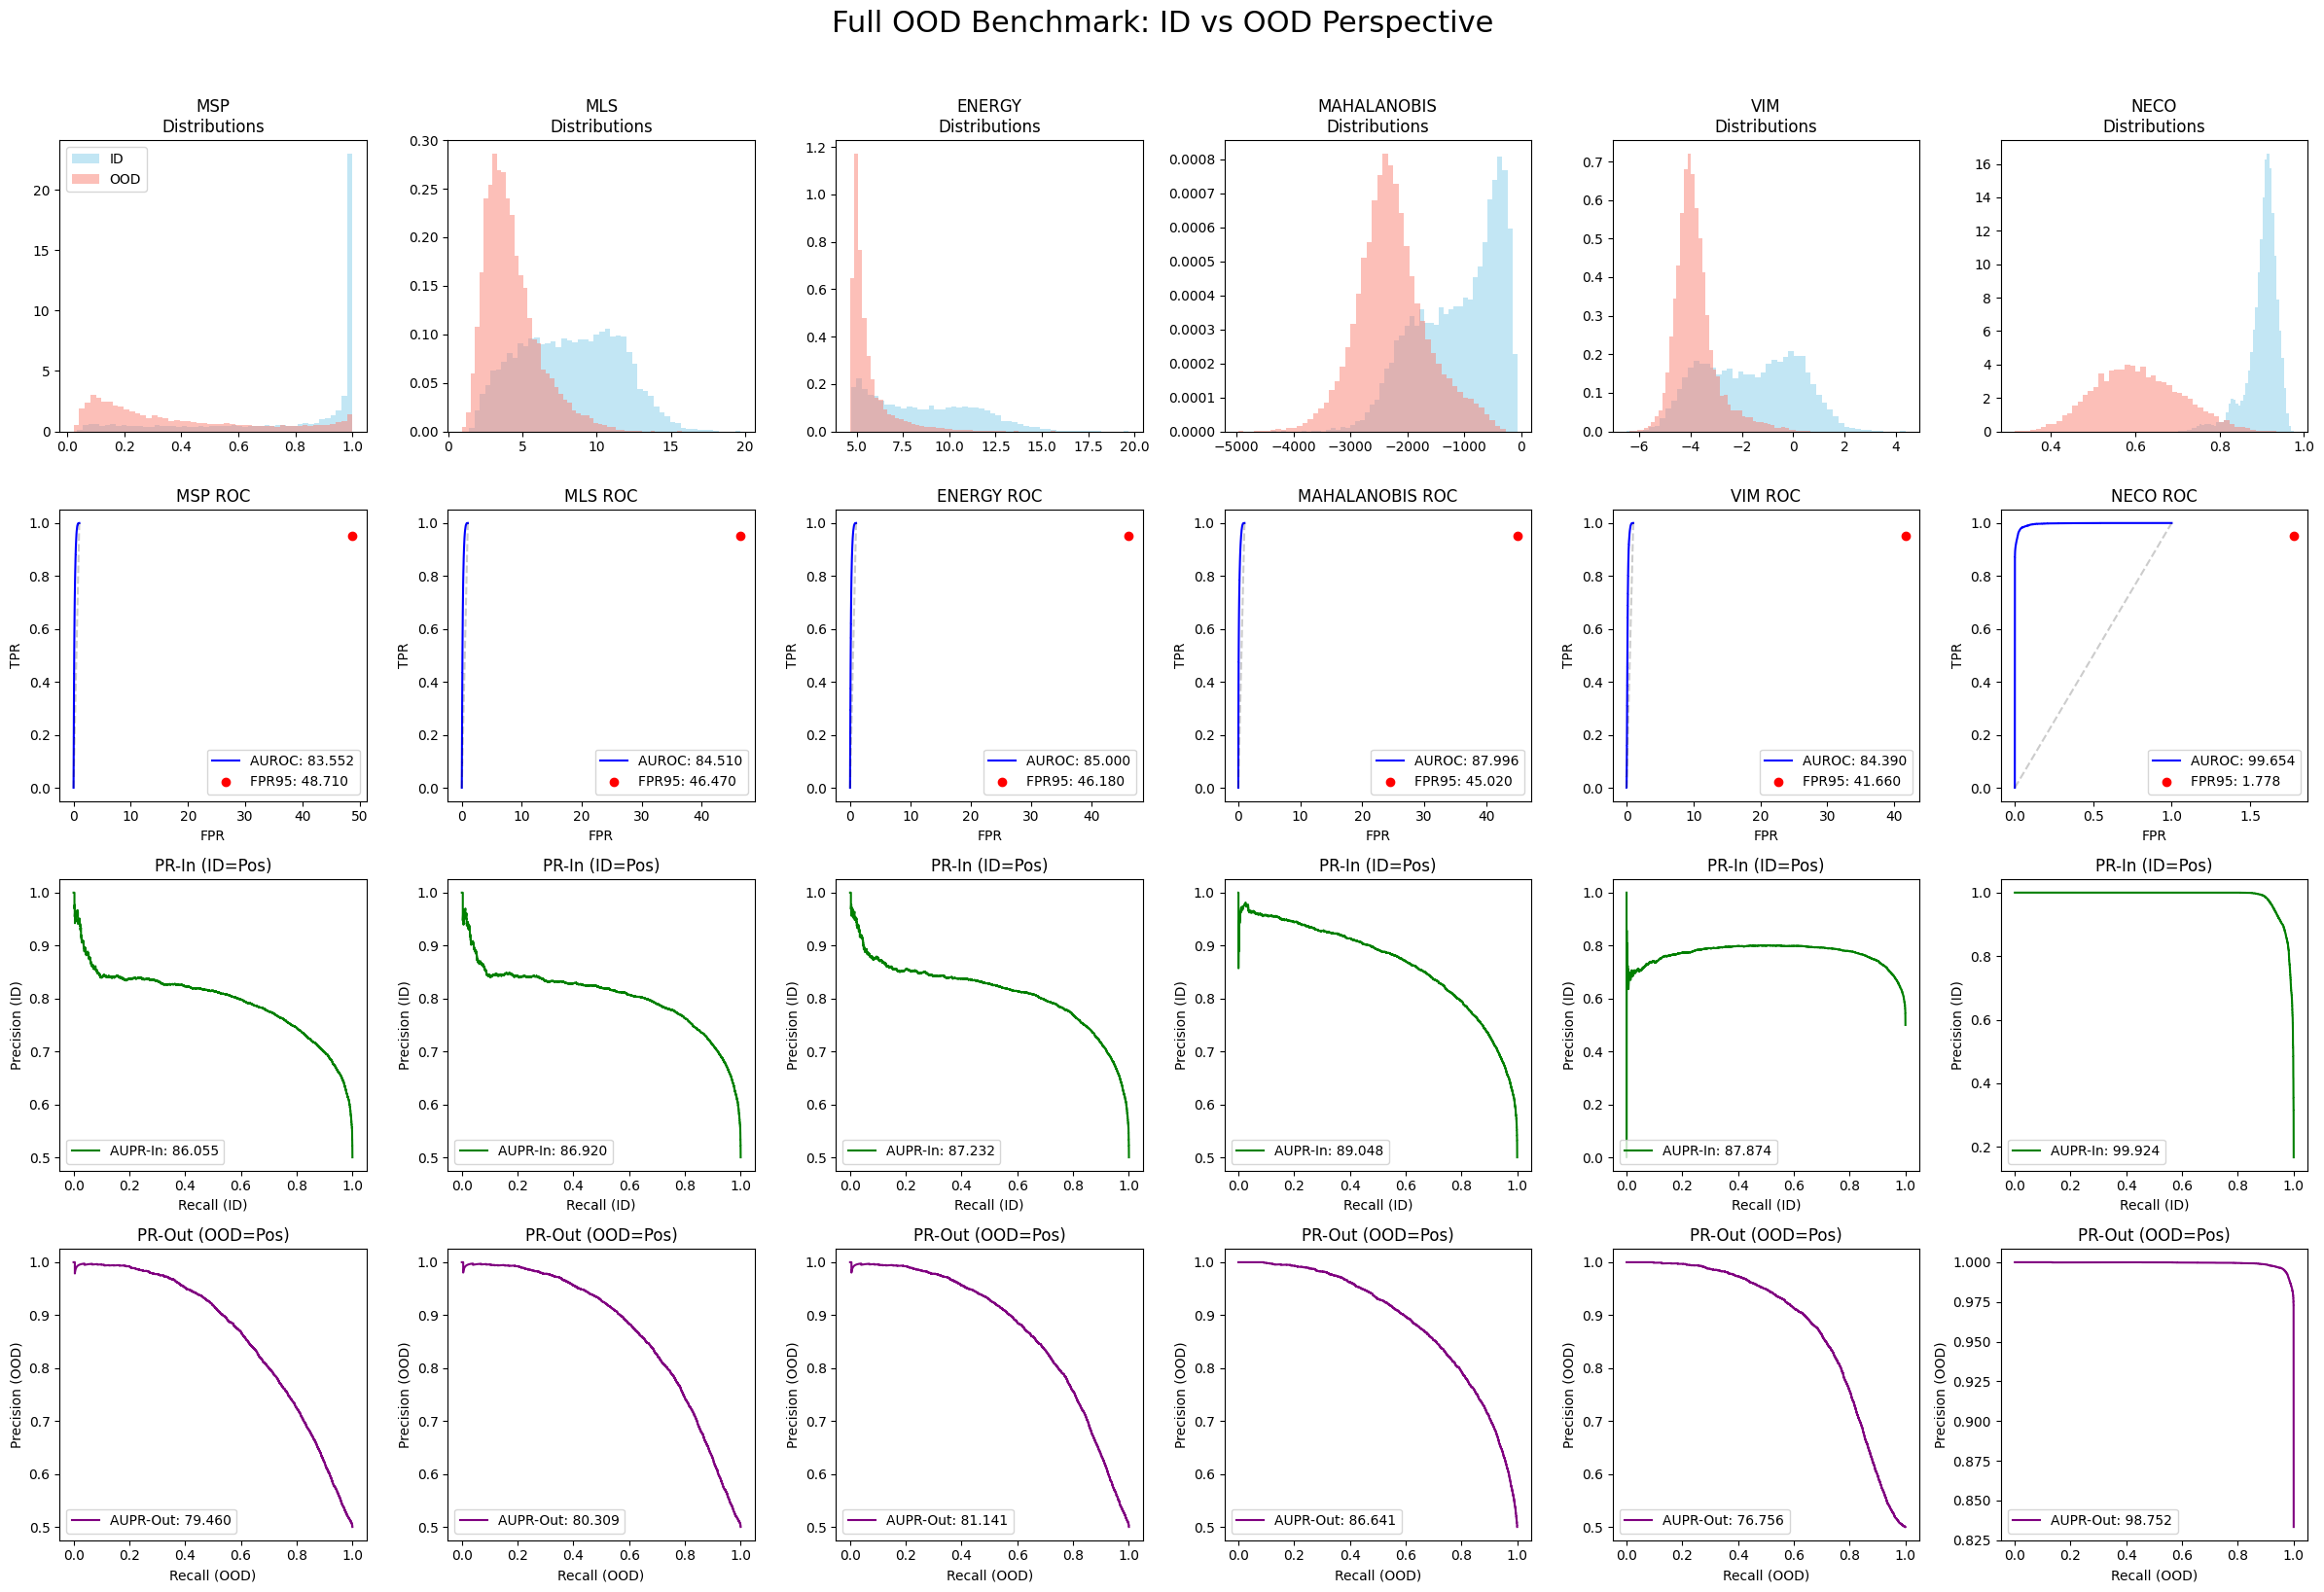

In [351]:
plot_comparisons(id_scores, ood_scores, all_metrics_evaluated)

NECO score is better than every other ood_scores on svhn dataset.